# 算法 依赖以及必要的函数

需要修改的内容：
profile_ml_matched_filter 阈值
所有函数的代码简洁性和可读性

c:\Users\RS\.conda\envs\matchedfiltermethod\Lib\site-packages\numpy\lib\polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

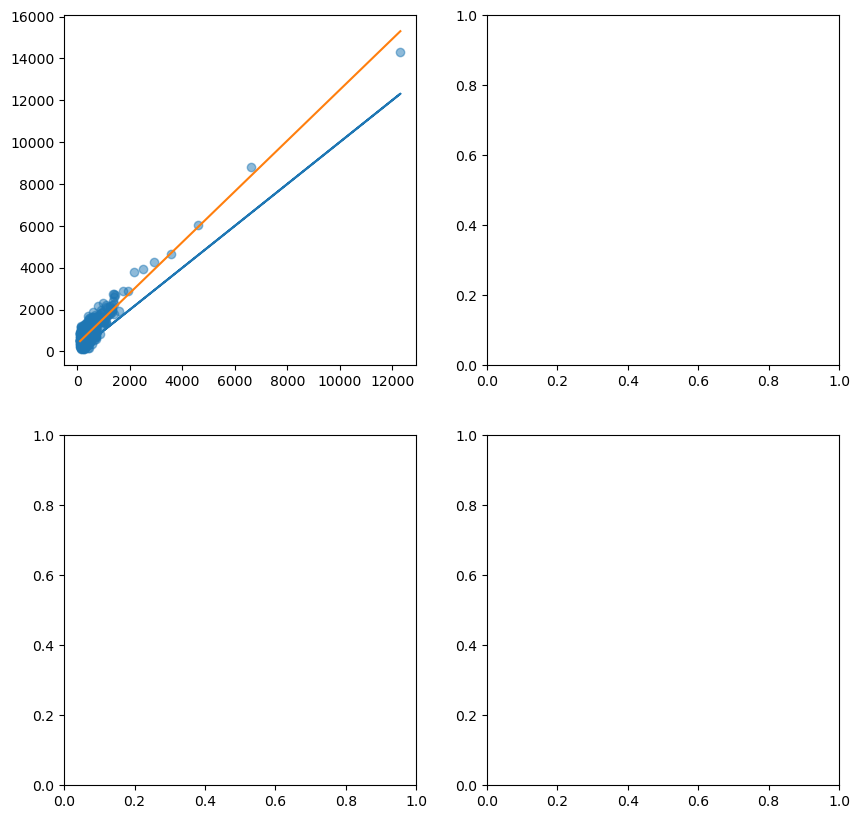

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import seaborn as sns

import os
import sys
import time

sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src")
from algorithms import matched_filter_variants as mfs
from algorithms import matched_filter_all as mfa
from utils.satellites_data import general_functions as gf
from utils import satellites_data as sd
from utils import generate_radiance_lut_and_uas as glut
from utils import simulate_images as si


def polyfit_plot(enhancements, resultlist, ax, labelstr):
    slope, intercept = np.polyfit(enhancements, resultlist, 1)
    x_fit = np.linspace(min(enhancements), max(enhancements), 100)
    y_fit = slope * x_fit + intercept
    if intercept > 0:
        ax.plot(
            x_fit, y_fit, label=f"{labelstr}:y = {slope:.2f}x + {np.abs(intercept):.2f}"
        )
    elif intercept < 0:
        ax.plot(
            x_fit, y_fit, label=f"{labelstr}:y = {slope:.2f}x - {np.abs(intercept):.2f}"
        )
    else:
        ax.plot(x_fit, y_fit, label=f"{labelstr}:y = {slope:.2f}x")


def set_plot_details(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()


def test(method, ax, *args):
    tif_file_path = r"F:\\AHSI_part1\\GF5B_AHSI_E100.0_N26.4_20231004_011029_L10000400374\\GF5B_AHSI_E100.0_N26.4_20231004_011029_L10000400374_SW.tif"
    bands, radiance = sd.AHSI_data.get_calibrated_radiance(tif_file_path, 2100, 2500)
    # define the path of the unit absorption spectrum file
    ahsi_unit_absorption_spectrum_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_50000.txt"
    bands, uas = gf.open_unit_absorption_spectrum(
        ahsi_unit_absorption_spectrum_path, 2100, 2500
    )
    # call the main function to process the radiance file

# 算法 运行正常性测试

## 常规匹配滤波算法

### 整幅影像计算

running time: 0.09962177276611328
Mean: 0.00 ppm
Std: 995.54 ppm
Max: 41461.44 ppm
Min: -1295.66 ppm


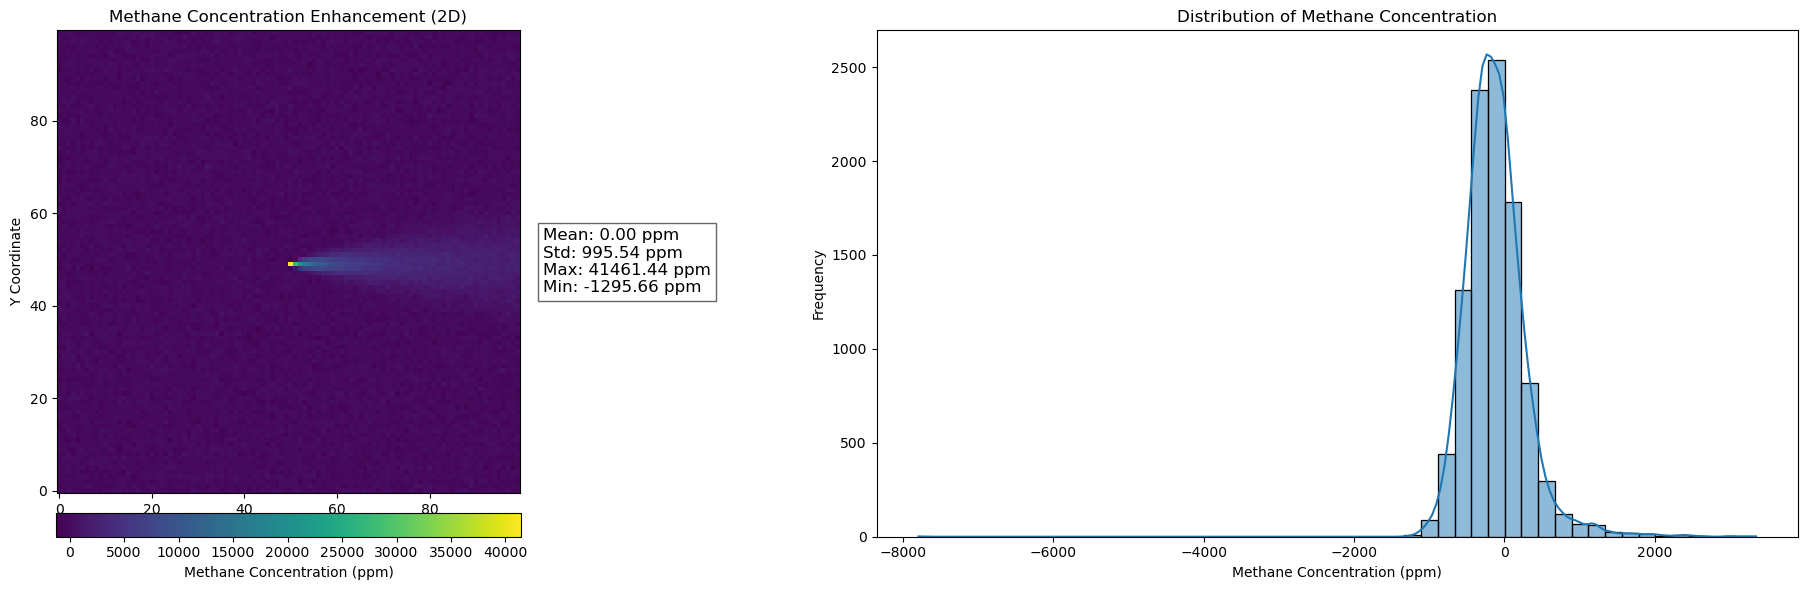

49253.14539113571
41461.43642512403
running time: 0.10563158988952637
Mean: 0.00 ppm
Std: 500.91 ppm
Max: 2681.31 ppm
Min: -2820.86 ppm


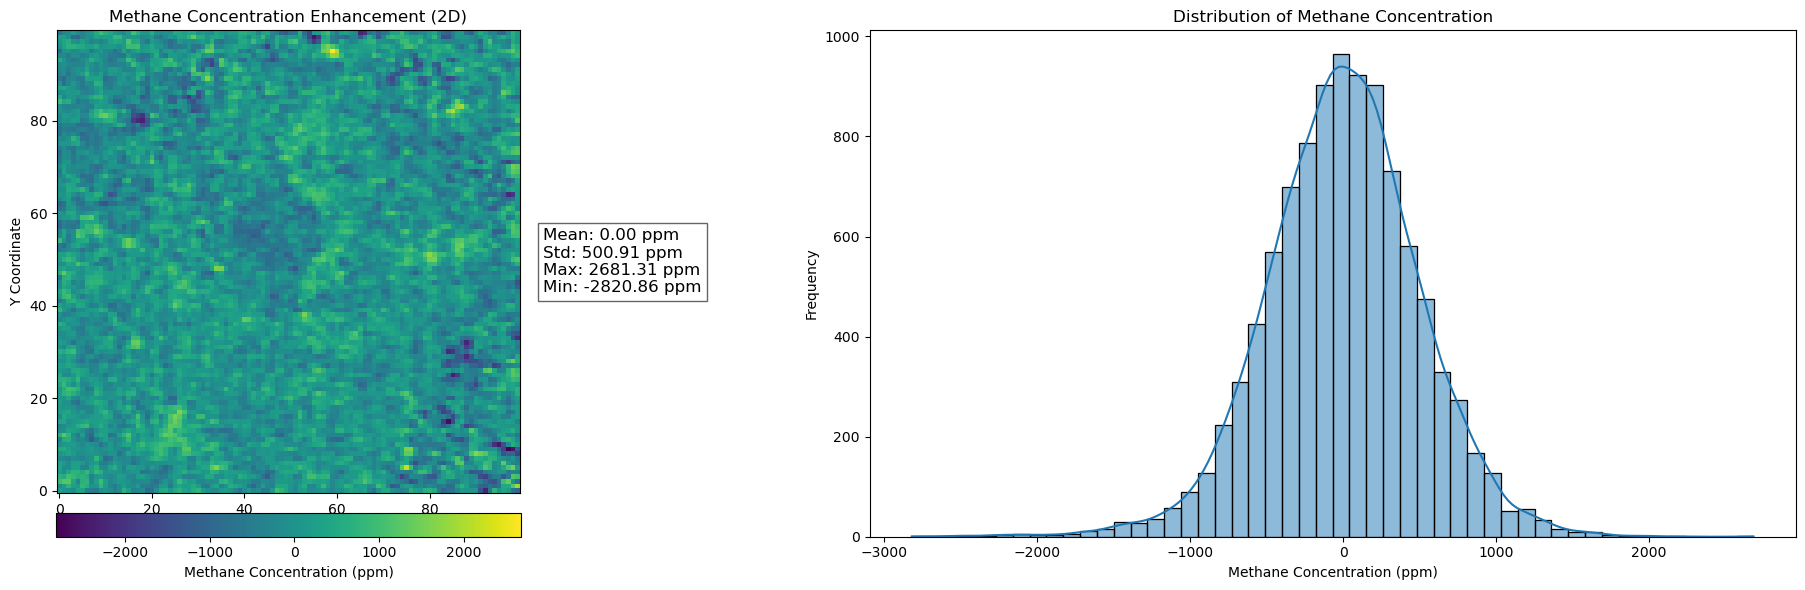

In [32]:
def mf_run_plot(ax, *args):
    _, uas = gu.generate_range_uas_AHSI(0, 36000, 2150, 2500)
    resultlist = []
    enhancements = np.arange(0, 20000, 500)
    for enhancement in enhancements:
        # 生成2%像素浓度增强的模拟影像
        simulated_image, enhanced_mask, unenhanced_mask = enhancement_2perc(enhancement)
        # 使用匹配滤波算法计算浓度增强
        result = matched_filter(simulated_image, uas, *args)
        # 计算增强和未增强像素的平均浓度
        enhanced = result[enhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax.plot(
            enhancement * np.ones(len(enhanced)),
            enhanced,
            marker="o",
            markersize=1,
            linestyle="None",
        )

    polyfit_plot(enhancements, resultlist, ax, "matched filter")


def matched_filter_test():
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()
    mf_run_plot(ax1, False, False, False)
    mf_run_plot(ax2, True, False, False)
    mf_run_plot(ax3, False, True, False)
    mf_run_plot(ax4, False, True, True)
    set_plot_details(ax1, "Original MF", "Enhancement", "Concentration")
    set_plot_details(
        ax2, "Original MF with albedoadjust ", "Enhancement", "Concentration"
    )
    set_plot_details(ax3, "Original MF with iteration", "Enhancement", "Concentration")
    set_plot_details(
        ax4, "Original MF with iteration and l1filter", "Enhancement", "Concentration"
    )

    plt.tight_layout()
    plt.show()

    return None


def matched_filter_simulated_image_test():
    plume = np.load(
        r"C:\Users\RS\VSCode\matchedfiltermethod\src\data\simulated_plumes\gaussianplume_1000_2_stability_D.npy"
    )
    simulated_radiance_cube = si.simulate_satellite_images_with_plume(
        "AHSI", plume, 2150, 2500, 0.01
    )
    # unit_absoprtion_spectrum = glut.generate_satellite_uas_for_specific_range_from_lut()
    unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"
    _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
        unit_absoprtion_spectrum_path, 2150, 2500
    )
    startime = time.time()
    methane_concentration = mfs.matched_filter(
        simulated_radiance_cube, unit_absoprtion_spectrum, False, False
    )
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap="viridis", origin="lower")
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(
        im, ax=axes[0], orientation="horizontal", shrink=0.7, fraction=0.046, pad=0.04
    )
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (
        f"Mean: {mean_concentration:.2f} ppm\n"
        f"Std: {std_concentration:.2f} ppm\n"
        f"Max: {max_concentration:.2f} ppm\n"
        f"Min: {min_concentration:.2f} ppm"
    )
    axes[0].text(
        1.05,
        0.5,
        stats_text,
        transform=axes[0].transAxes,
        fontsize=12,
        va="center",
        bbox=dict(facecolor="white", alpha=0.6),
    )

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten() - plume.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()
    # 显示图表
    plt.show()
    print(plume.max())
    print(methane_concentration.max())
    return


def matched_filter_real_image_test():
    filepath = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222_SW.tif"
    outputfolder = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\mf_result\\"
    filename = os.path.basename(filepath)
    outputfile = os.path.join(outputfolder, filename)
    if os.path.exists(outputfile):
        return

    _, image_cube = sd.AHSI_data.get_calibrated_radiance(filepath, 2150, 2500)
    # 取整幅影像的 100*100 切片进行测试
    image_sample_cube = image_cube[:, 500:600, 700:800]
    unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"
    _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
        unit_absoprtion_spectrum_path, 2150, 2500
    )
    startime = time.time()
    methane_concentration = mfs.matched_filter(
        image_sample_cube, unit_absoprtion_spectrum, False, False
    )
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # sd.AHSI_data.export_ahsi_array_to_tiff(
    #     methane_concentration,
    #     filepath,
    #     outputfolder,
    # )

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap="viridis", origin="lower")
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(
        im, ax=axes[0], orientation="horizontal", shrink=0.7, fraction=0.046, pad=0.04
    )
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (
        f"Mean: {mean_concentration:.2f} ppm\n"
        f"Std: {std_concentration:.2f} ppm\n"
        f"Max: {max_concentration:.2f} ppm\n"
        f"Min: {min_concentration:.2f} ppm"
    )
    axes[0].text(
        1.05,
        0.5,
        stats_text,
        transform=axes[0].transAxes,
        fontsize=12,
        va="center",
        bbox=dict(facecolor="white", alpha=0.6),
    )

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()
    # 显示图表
    plt.show()

    return


matched_filter_simulated_image_test()
matched_filter_real_image_test()

### column-wise 进行计算

running time: 0.12309980392456055
Mean: 0.00 ppm
Std: 684.40 ppm
Max: 11182.39 ppm
Min: -3899.90 ppm


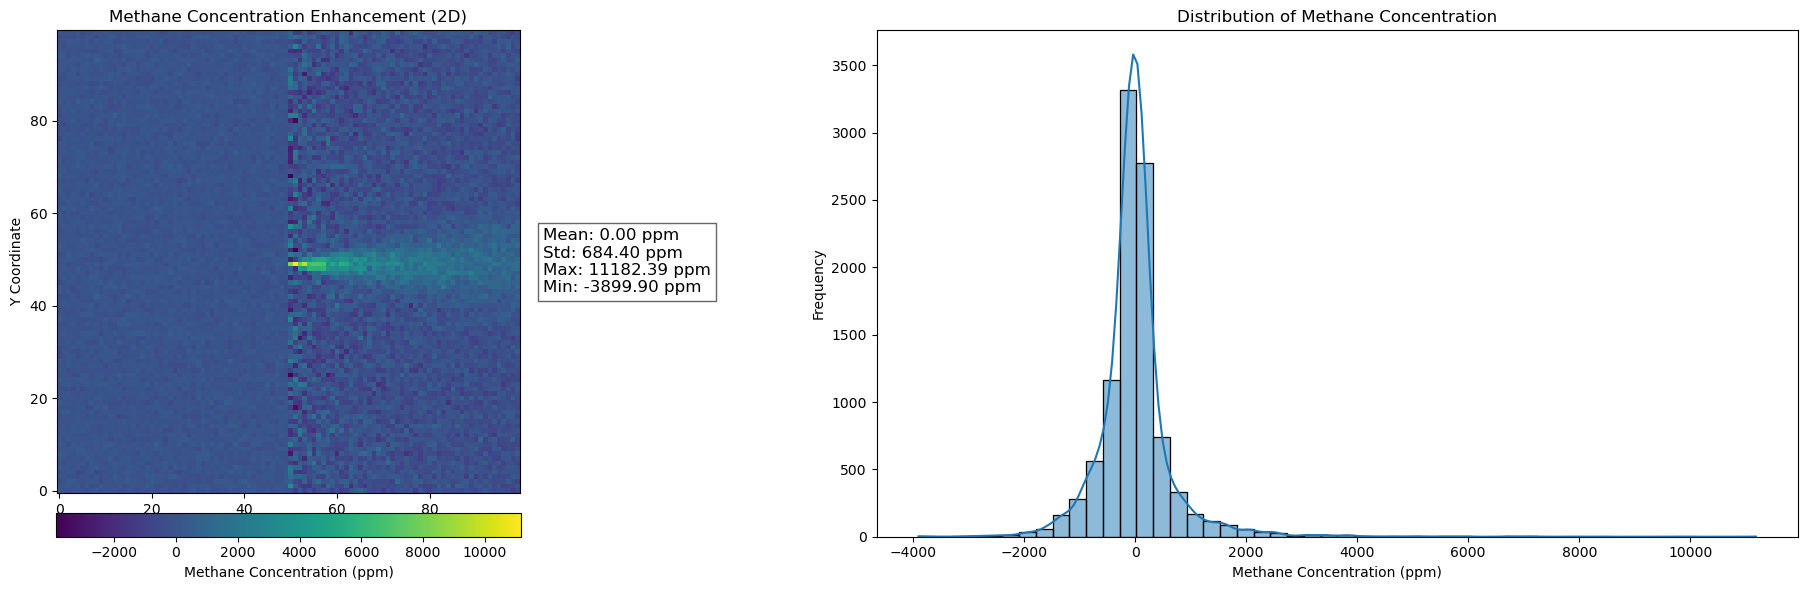

running time: 0.12242841720581055
Mean: 0.00 ppm
Std: 267.46 ppm
Max: 1210.32 ppm
Min: -1217.90 ppm


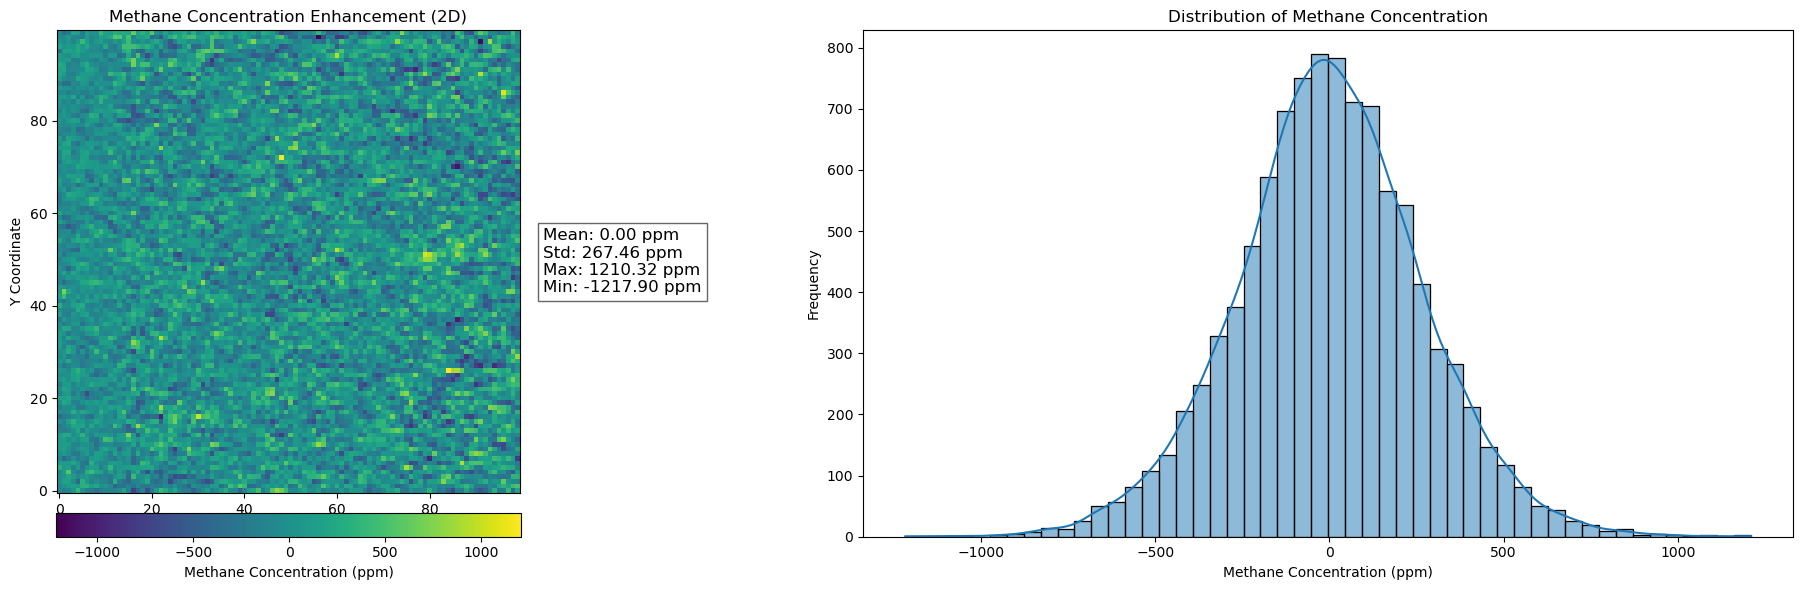

In [24]:


def cw_matched_filter_simulated_image_test():
    plume = np.load(
        r"C:\Users\RS\VSCode\matchedfiltermethod\src\data\simulated_plumes\gaussianplume_1000_2_stability_D.npy"
    )
    simulated_radiance_cube = si.simulate_satellite_images_with_plume(
        "AHSI", plume, 2150, 2500, 0.01
    )
    unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"
    _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
        unit_absoprtion_spectrum_path, 2150, 2500
    )
    startime = time.time()
    methane_concentration = mfs.columnwise_matched_filter(
        simulated_radiance_cube, unit_absoprtion_spectrum, False, False
    )
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap="viridis", origin="lower")
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(
        im, ax=axes[0], orientation="horizontal", shrink=0.7, fraction=0.046, pad=0.04
    )
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (
        f"Mean: {mean_concentration:.2f} ppm\n"
        f"Std: {std_concentration:.2f} ppm\n"
        f"Max: {max_concentration:.2f} ppm\n"
        f"Min: {min_concentration:.2f} ppm"
    )
    axes[0].text(
        1.05,
        0.5,
        stats_text,
        transform=axes[0].transAxes,
        fontsize=12,
        va="center",
        bbox=dict(facecolor="white", alpha=0.6),
    )

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()
    # 显示图表
    plt.show()

    return



def cw_matched_filter_real_image_test():
    filepath = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222_SW.tif"
    outputfolder = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\mf_result\\"
    filename = os.path.basename(filepath)
    outputfile = os.path.join(outputfolder, filename)
    if os.path.exists(outputfile):
        return

    _, image_cube = sd.AHSI_data.get_calibrated_radiance(filepath, 2150, 2500)
    image_sample_cube = image_cube[:, 500:600, 700:800]
    unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"

    _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
        unit_absoprtion_spectrum_path, 2150, 2500
    )
    
    startime = time.time()
    methane_concentration = mfs.columnwise_matched_filter(
        data_cube=image_sample_cube,
        unit_absorption_spectrum=unit_absoprtion_spectrum,
        iterate=False,
        albedoadjust=False,
    )
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # sd.AHSI_data.export_ahsi_array_to_tiff(
    #     methane_concentration,
    #     filepath,
    #     outputfolder,
    # )

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap='viridis', origin='lower')
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(im, ax=axes[0], orientation='horizontal', shrink=0.7, fraction=0.046, pad=0.04)
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (f"Mean: {mean_concentration:.2f} ppm\n"
                f"Std: {std_concentration:.2f} ppm\n"
                f"Max: {max_concentration:.2f} ppm\n"
                f"Min: {min_concentration:.2f} ppm")
    axes[0].text(1.05, 0.5, stats_text, transform=axes[0].transAxes,
                fontsize=12, va='center', bbox=dict(facecolor='white', alpha=0.6))

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()

    # 显示图表
    plt.show()

    return 

cw_matched_filter_simulated_image_test()
cw_matched_filter_real_image_test()

## 多层匹配滤波算法

### 整幅图像进行计算

No significant plume detected.
Iteration 1: Converged with std change 1.0348813063146736.
(100, 100)
running time: 3.167844533920288
Mean: 0.00 ppm
Std: 455.84 ppm
Max: 2584.68 ppm
Min: -2564.79 ppm


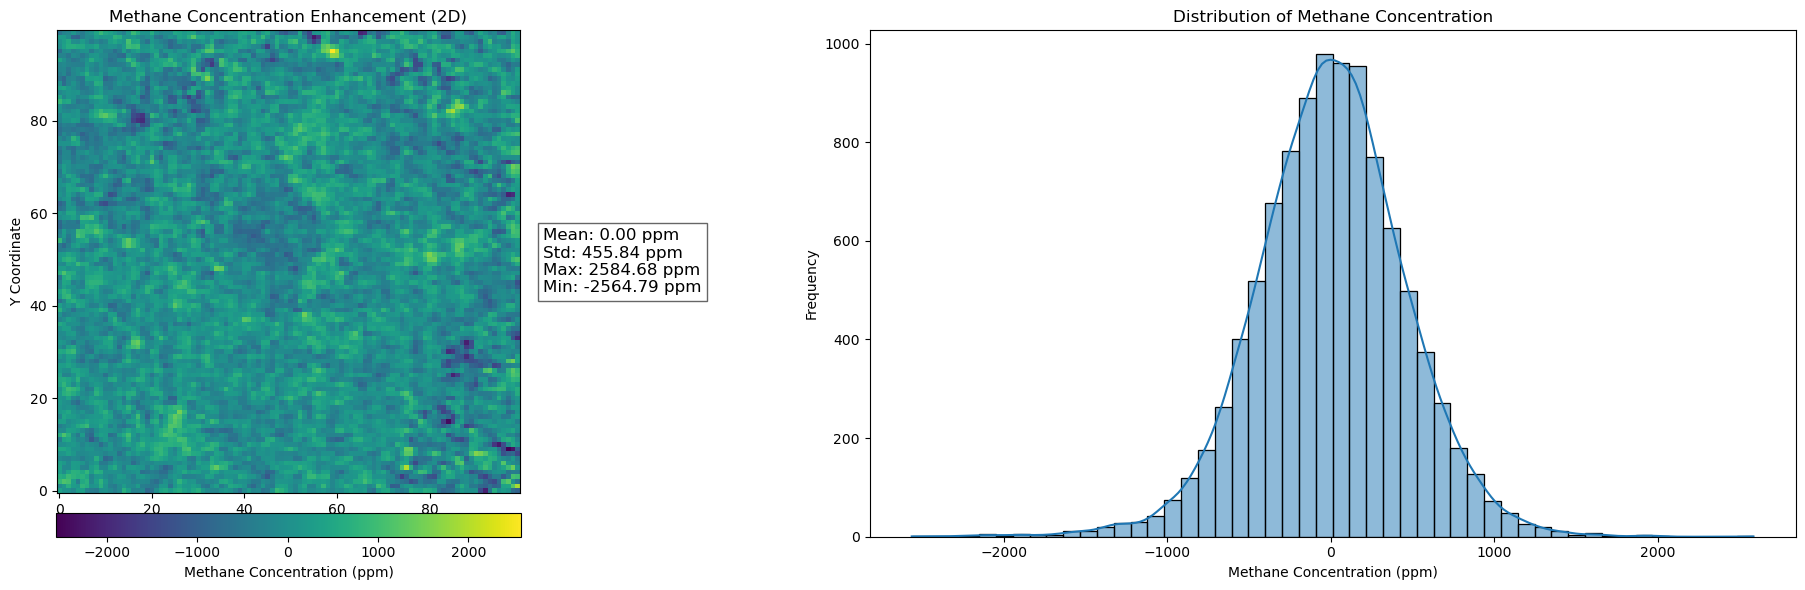

In [2]:

def mlmf_run_plot(ax1, ax2, *args):
    uaslist = []
    _, uas = gu.generate_range_uas_AHSI(0, 36000, 2150, 2500)
    uaslist.append(uas)
    uasrange = np.arange(4000, 46000, 4000)
    for i in uasrange:
        _, uas = gu.generate_range_uas_AHSI(i, i + 6000, 2150, 2500)
        uaslist.append(uas)

    resultlist = []
    resultlist2 = []
    enhancements = np.arange(0, 20000, 500)
    for enhancement in enhancements:
        # 生成2%像素浓度增强的模拟影像
        simulated_image, enhanced_mask, unenhanced_mask = enhancement_2perc(enhancement)
        # 使用匹配滤波算法计算浓度增强
        originalresult, result = mfs.ml_matched_filter(simulated_image, uaslist, *args)
        # 计算增强和未增强像素的平均浓度

        enhanced = originalresult[enhanced_mask]
        unenhanced = originalresult[unenhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax1.plot(
            enhancement * np.ones(len(enhanced)),
            enhanced,
            marker="o",
            markersize=1,
            linestyle="None",
        )

        enhanced2 = result[enhanced_mask]
        unenhanced2 = result[unenhanced_mask]
        resultlist2.append(np.mean(enhanced2))
        ax2.plot(
            enhancement * np.ones(len(enhanced2)),
            enhanced2,
            marker="o",
            markersize=1,
            linestyle="None",
        )
    polyfit_plot(enhancements, resultlist, ax1, "original matched filter")
    polyfit_plot(enhancements, resultlist2, ax2, "ML matched filter")


def ml_matched_filter_test():
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    mlmf_run_plot(ax1, ax2, False)
    mlmf_run_plot(ax3, ax4, True)

    set_plot_details(ax1, "original MF", "Enhancement", "Concentration")
    set_plot_details(ax2, "ML MF", "Enhancement", "Concentration")
    set_plot_details(
        ax3, "original MF with albedoadjust", "Enhancement", "Concentration"
    )
    set_plot_details(ax4, "ML MF with albedoadjust", "Enhancement", "Concentration")

    plt.tight_layout()
    plt.show()

    return None


def ml_matched_filter_simulation_test():
    plume = np.load(
        r"C:\Users\RS\VSCode\matchedfiltermethod\src\data\simulated_plumes\gaussianplume_1000_2_stability_D.npy"
    )
    simulated_radiance_cube = si.simulate_satellite_images_with_plume(
        "AHSI", plume, 25,0,2150, 2500, 0.01
    )
    # unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"
    # _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
    #     unit_absoprtion_spectrum_path, 2150, 2500
    # )
    _,unit_absorption_spectrum = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",0,36000,2150,2500,25,0)
    startime = time.time()
    methane_concentration = mfa.ml_matched_filter(
        simulated_radiance_cube, unit_absorption_spectrum
    )
    print(methane_concentration.shape)
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap="viridis", origin="lower")
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(
        im, ax=axes[0], orientation="horizontal", shrink=0.7, fraction=0.046, pad=0.04
    )
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (
        f"Mean: {mean_concentration:.2f} ppm\n"
        f"Std: {std_concentration:.2f} ppm\n"
        f"Max: {max_concentration:.2f} ppm\n"
        f"Min: {min_concentration:.2f} ppm"
    )
    axes[0].text(
        1.05,
        0.5,
        stats_text,
        transform=axes[0].transAxes,
        fontsize=12,
        va="center",
        bbox=dict(facecolor="white", alpha=0.6),
    )

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()
    # 显示图表
    plt.show()

    return


def ml_matched_filter_real_image_test():
    filepath = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222\\GF5B_AHSI_W102.8_N32.3_20220424_003345_L10000118222_SW.tif"
    outputfolder = "C:\\Users\\RS\\Desktop\\GF5-02_李飞论文所用数据\\mf_result\\"
    filename = os.path.basename(filepath)
    outputfile = os.path.join(outputfolder, filename)
    if os.path.exists(outputfile):
        return

    _, image_cube = sd.AHSI_data.get_calibrated_radiance(filepath, 2150, 2500)
    image_sample_cube = image_cube[:, 500:600, 700:800]
    unit_absoprtion_spectrum_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\uas_files\\AHSI_unit_absorption_spectrum.txt"

    # _, unit_absoprtion_spectrum = gf.open_unit_absorption_spectrum(
    #     unit_absoprtion_spectrum_path, 2150, 2500
    # )
    _,unit_absorption_spectrum = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",0,40000,2150,2500,25,0)
    startime = time.time()
    # methane_concentration = mfs.ml_matched_filter(
    #     data_cube=image_sample_cube,
    #     unit_absorption_spectrum_array=unit_absoprtion_spectrum,
    #     albedoadjust=False,
    # )
    methane_concentration = mfa.ml_matched_filter(
        image_sample_cube,unit_absorption_spectrum,modify_result=True
    )
    print(methane_concentration.shape)
    finish_time = time.time()
    print(f"running time: {finish_time - startime}")
    
    # # sd.AHSI_data.export_ahsi_array_to_tiff(
    # #     methane_concentration,
    # #     filepath,
    # #     outputfolder,
    # # )

    # 计算统计信息
    mean_concentration = np.mean(methane_concentration)
    std_concentration = np.std(methane_concentration)
    max_concentration = np.max(methane_concentration)
    min_concentration = np.min(methane_concentration)
    print(f"Mean: {mean_concentration:.2f} ppm")
    print(f"Std: {std_concentration:.2f} ppm")
    print(f"Max: {max_concentration:.2f} ppm")
    print(f"Min: {min_concentration:.2f} ppm")

    # 创建图形和子图
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 子图1：甲烷浓度二维数组的可视化
    im = axes[0].imshow(methane_concentration, cmap='viridis', origin='lower')
    axes[0].set_title("Methane Concentration Enhancement (2D)")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")

    # 将 colorbar 移到下方
    cbar = fig.colorbar(im, ax=axes[0], orientation='horizontal', shrink=0.7, fraction=0.046, pad=0.04)
    cbar.set_label("Methane Concentration (ppm)")

    # 在第一个子图上添加统计信息
    stats_text = (f"Mean: {mean_concentration:.2f} ppm\n"
                f"Std: {std_concentration:.2f} ppm\n"
                f"Max: {max_concentration:.2f} ppm\n"
                f"Min: {min_concentration:.2f} ppm")
    axes[0].text(1.05, 0.5, stats_text, transform=axes[0].transAxes,
                fontsize=12, va='center', bbox=dict(facecolor='white', alpha=0.6))

    # 子图2：甲烷浓度分布的直方图和 KDE 图
    sns.histplot(methane_concentration.flatten(), bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Methane Concentration")
    axes[1].set_xlabel("Methane Concentration (ppm)")
    axes[1].set_ylabel("Frequency")

    # 调整布局
    fig.tight_layout()

    # 显示图表
    plt.show()

    return 

# ml_matched_filter_simulation_test()
ml_matched_filter_real_image_test()

### column-wise 进行计算

In [ ]:

from algorithms.matchedfilter_methods import columnwise_ml_matched_filter

# modified matched filter algorithm 逐列计算
def columnwise_ML_matched_filter(data_array: np.array, stacked_unit_absorption_spectrum: np.array, is_iterate=False,
                   is_albedo=False, is_filter=False, is_columnwise=False) -> np.array:
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.

    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param is_iterate: flag to decide whether to iterate the matched filter
    :param is_albedo: flag to decide whether to do the albedo correction
    :param is_filter: flag to decide whether to add the l1-filter correction
    :return: numpy array of methane enhancement result
    """
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_array.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 遍历不同列数，目的是为了消除 不同传感器之间带来的误差
    if is_columnwise:
        for col_index in range(cols):
            # 获取当前列的数据
            current_column = data_array[:, :, col_index]
            # 获取当前列的非空行的 索引 以及 数目
            valid_rows = ~np.isnan(current_column[0, :])
            count_not_nan = np.count_nonzero(valid_rows)
            # 对于全为空的列，直接将浓度值设为 nan
            if count_not_nan == 0:
                concentration[:, col_index] = np.nan
                continue

            # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
            background_spectrum = np.nanmean(current_column, axis=1)
            target_spectrum = background_spectrum*stacked_unit_absorption_spectrum[0,:]

            # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
            radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None]
            covariance = np.zeros((bands, bands))
            for i in range(count_not_nan):
                covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
            covariance = covariance/count_not_nan
            covariance_inverse = np.linalg.inv(covariance)

            # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
            albedo = np.ones((rows, cols))
            if is_albedo:
                albedo[valid_rows, col_index] = (
                        (current_column[:, valid_rows].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )

            # 基于最优化公式计算每个像素的甲烷浓度增强值
            up = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum)
            down = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[valid_rows, col_index] = up / down
            
            levelon = True
            # 计算浓度增强值的均值和标准差
            mean_concentration = np.nanmean(concentration[valid_rows, col_index])  # 忽略 NaN 值
            std_concentration = np.nanstd(concentration[valid_rows, col_index])    # 忽略 NaN 值
            # 使用均值加一个标准差作为自适应阈值
            adaptive_threshold = mean_concentration + std_concentration
            while levelon:
                high_concentration_mask = concentration[valid_rows, col_index] > adaptive_threshold
                # 获取这个阈值的单位吸收谱，可以通过插值查找表获得
                # 使用新的单位吸收谱重新计算目标光谱
                background_spectrum = np.nanmean(current_column[:,valid_rows] + albedo[valid_rows,col_index]*concentration[valid_rows,col_index]*target_spectrum[:, np.newaxis], axis=1)
                background_spectrum = background_spectrum + adaptive_threshold*stacked_unit_absorption_spectrum[1,:]
                target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[1,:])
                radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None] - albedo[valid_rows,col_index]*(concentration[valid_rows,col_index]-adaptive_threshold)*target_spectrum[:, np.newaxis] 
                covariance = np.zeros((bands, bands))
                for i in range(valid_rows.shape[0]):
                    covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                covariance = covariance/count_not_nan
                covariance_inverse = np.linalg.inv(covariance)
                # 基于新的目标光谱重新计算高浓度像素的甲烷浓度增强值
                up = (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @ target_spectrum)
                down = albedo[valid_rows, col_index][high_concentration_mask] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                # 直接更新原数组
                valid_indices = np.where(valid_rows)[0]
                high_concentration_indices = valid_indices[high_concentration_mask]
                concentration[high_concentration_indices, col_index] = up / down + adaptive_threshold
                # 计算浓度增强值的均值和标准差
                mean_concentration = np.nanmean(concentration[valid_rows, col_index])  # 忽略 NaN 值
                std_concentration = np.nanstd(concentration[valid_rows, col_index])    # 忽略 NaN 值
                # 使用均值加一个标准差作为自适应阈值
                new_adaptive_threshold = mean_concentration + std_concentration
                if np.abs((new_adaptive_threshold-adaptive_threshold)/adaptive_threshold) < 0.1:
                    adaptive_threshold = new_adaptive_threshold
                else:
                    levelon = False

            # 判断是否进行迭代，若是，则进行如下迭代计算
            if is_iterate:
                l1filter = np.zeros((rows, cols))
                epsilon = np.finfo(np.float32).tiny
                for iter_num in range(5):
                    if is_filter:
                        l1filter[valid_rows, col_index] = 1 / (concentration[valid_rows, col_index] + epsilon)
                    else:
                        l1filter[valid_rows, col_index] = 0
                    
                    # 更新背景光谱和目标光谱
                    column_replacement = current_column[:, valid_rows] - (albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None]
                    # 计算更新后的 背景光谱 和 目标谱
                    background_spectrum = np.mean(column_replacement, axis=1)
                    target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])
                    # 基于新的目标谱 和 背景光谱 计算协方差矩阵
                    radiancediff_with_bg = current_column[:, valid_rows] -(albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None] - background_spectrum[:,None]
                    covariance = np.zeros((bands, bands))
                    for i in range(valid_rows.shape[0]):
                        covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                    covariance = covariance/count_not_nan
                    covariance_inverse = np.linalg.inv(covariance)

                    # 计算新的甲烷浓度增强值
                    up = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum) - l1filter[valid_rows, col_index]
                    down = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                    concentration[valid_rows, col_index] = np.maximum(up / down, 0.0)
                    high_concentration_mask = concentration[valid_rows, col_index] > 5000
                    
                    if np.any(high_concentration_mask):
                        # 使用新的单位吸收谱重新计算目标光谱
                        con = concentration[valid_rows, col_index].copy()
                        background_spectrum = np.nanmean(current_column[:,valid_rows] - albedo[valid_rows,col_index]*con*target_spectrum[:, np.newaxis], axis=1)
                        target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum)
                        radiancediff_with_bg = current_column[:, valid_rows] -albedo[valid_rows,col_index]*con*target_spectrum[:, np.newaxis] - background_spectrum[:, None]
                        covariance = np.zeros((bands, bands))
                        for i in range(valid_rows.shape[0]):
                            covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                        covariance = covariance/count_not_nan
                        covariance_inverse = np.linalg.inv(covariance)
                        # 基于新的目标光谱重新计算高浓度像素的甲烷浓度增强值
                        up = (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @ target_spectrum)
                        down = albedo[valid_rows, col_index][high_concentration_mask] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                        # 直接更新原数组
                        valid_indices = np.where(valid_rows)[0]
                        high_concentration_indices = valid_indices[high_concentration_mask]
                        concentration[high_concentration_indices, col_index] = up / down + 2500

    if not is_columnwise:
        count_not_nan = np.count_nonzero(~np.isnan(data_array[0, :, :]))
        background_spectrum = np.nanmean(data_array, axis=(1,2))
        target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])   
        radiancediff_with_bg = data_array - background_spectrum[:, None, None]
        covariance = np.zeros((bands, bands))
        for i in range(rows):
            for j in range(cols):
                covariance = covariance + np.outer(radiancediff_with_bg[:, i, j], radiancediff_with_bg[:, i, j])
        covariance = covariance / count_not_nan
        covariance_inverse = np.linalg.inv(covariance)
        albedo = np.ones((rows, cols))
        for row_index in range(rows):
            for col_index in range(cols):
                if is_albedo:
                    albedo[row_index, col_index] = (
                        (data_array[:, row_index, col_index].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                    )
                up = (radiancediff_with_bg[:,row_index,col_index].T @ covariance_inverse @ target_spectrum)
                down = albedo[row_index, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                concentration[row_index, col_index] = up / down
        
        if is_iterate:
            l1filter = np.zeros((rows, cols))
            epsilon = np.finfo(np.float32).tiny
            iter_data = data_array.copy()
            
            for iter_num in range(5):
                if is_filter:
                    l1filter = 1 / (concentration + epsilon)
                iter_data = data_array - (
                    target_spectrum[:, None, None] * albedo[None, :, :] * concentration[None, :, :]
                )
                background_spectrum = np.nanmean(iter_data, axis=(1,2))
                target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])
                radiancediff_with_bg = data_array - background_spectrum[:, None, None]
                covariance = np.zeros((bands, bands))
                for i in range(rows):
                    for j in range(cols):
                        covariance += np.outer(radiancediff_with_bg[:, i, j], radiancediff_with_bg[:, i, j])
                covariance = covariance / count_not_nan
                covariance_inverse = np.linalg.inv(covariance)
                
                for row_index in range(rows):
                    for col_index in range(cols):
                        up = (radiancediff_with_bg[:, row_index, col_index].T @ covariance_inverse @ target_spectrum)
                        down = albedo[row_index, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                        concentration[row_index, col_index] = np.maximum(up / down, 0)

    # 返回 甲烷浓度增强的结果
    return concentration



## lognornal 匹配滤波算法

### 整幅影像进行计算

In [ ]:
from algorithms.matchedfilter_methods import lognormal_matched_filter


def lognormal_mf_simulation_test():
    pass

def lognormal_mf_real_image_test():
    pass


### column-wise 进行计算

In [ ]:
from algorithms.matchedfilter_methods import columnwise_lognormal_matched_filter
# convert the radiance into log space 逐列计算
def columnwise_lognormal_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array):
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_cube.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    radiancediff_with_bg = data_cube - background_spectrum[:, None,None]
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(radiancediff_with_bg[:, row, col], radiancediff_with_bg[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.inv(covariance)

    for row in range(rows):
        for col in range(cols):
            # 基于最优化公式计算每个像素的甲烷浓度增强值
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = (target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator
    return concentration



##  Kalman filter 匹配滤波算法

### 整幅影像进行计算

In [ ]:
from algorithms.matchedfilter_methods import Kalman_filterr_matched_filter
def Kalman_filterr_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, albedoadjust, iterate, sparsity):
    
    return None

### column-wise进行计算

In [ ]:
from algorithms.matchedfilter_methods import columnwise_Kalman_filterr_matched_filter


def cw_kalman_filterr_matched_filter_simulation_test():
    pass

def cw_kalman_filterr_matched_filter_real_image_test():
    pass

# 算法 结果验证和评估

## 光谱测试
模拟的具备甲烷浓度增强的卫星光谱的匹配滤波拟合浓度增强

### 单层单位吸收光谱拟合

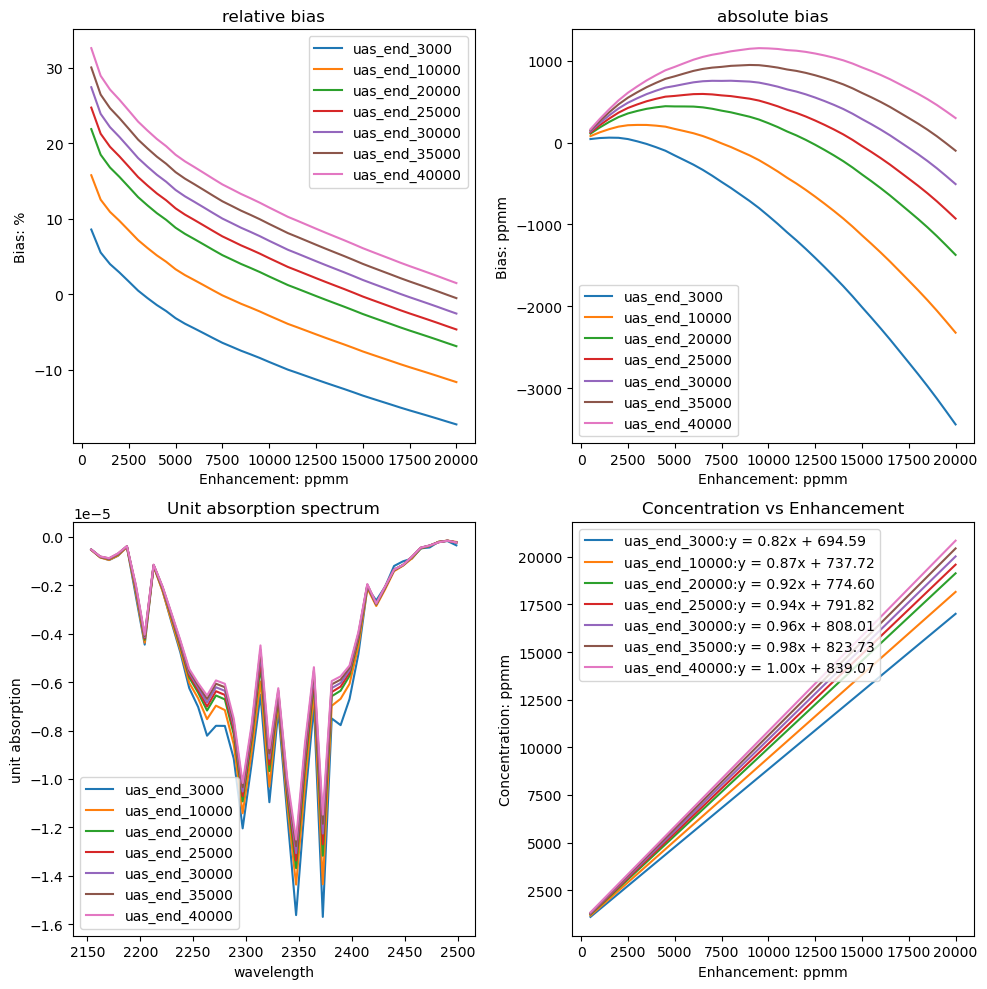

In [2]:

def profile_matched_filter(
    base_array: np.ndarray, data_array: np.ndarray, unit_absorption_spectrum: np.ndarray
)-> float:
    
    # 背景光谱和目标光谱
    background_spectrum = base_array
    target_spectrum = background_spectrum * unit_absorption_spectrum
    # 拟合斜率
    concentration, _, _, _ = np.linalg.lstsq(
        target_spectrum[:, np.newaxis], (data_array - background_spectrum), rcond=None
    )
    return concentration[0]



def spectrum_level_test1():
    """
    测试不同浓度增强下的甲烷廓线直接拟合的浓度结果。
    使用拟合区间不同的单位吸收光谱。
    """
    # 可视化
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = ax.flatten()
    # 选定不同范围下的单位吸收谱
    for end in [10000,15000,20000,25000,30000,35000,40000]:
        # 读取单位吸收光谱
        wvls,uas = glut.generate_satellite_uas_for_specific_range_from_lut(satellite_name="AHSI", start_enhancement=1000, end_enhancement=end, 
                                                                           lower_wavelength=2150, upper_wavelength=2500,sza=25,altitude=0)
        
        # 读取 背景光谱
        wvls,base_radiance = glut.get_satellite_radiance_spectrum_from_lut("AHSI", 0, 25, 0,2150,2500)
        
        
        
        # 设定浓度增强范围 0-20000 ppm*m 读取对应的radiance 光谱
        enhancements = np.arange(500, 20500, 500)
        wvls,radiance_list = glut.batch_get_radiance_from_lut("AHSI", enhancements, 25,0, 2150,2500)
        
        # 拟合甲烷浓度增强
        concentrationlist = []
        for i in range(radiance_list.shape[0]):
            concentration = profile_matched_filter(base_radiance, radiance_list[i,:], uas)
            concentrationlist.append(concentration)

        # 计算相对误差（百分率）和绝对误差
        absolute_biaslists = [concentrationlist[i] - enhancements[i] for i in range(len(enhancements))]
        relative_biaslists = [(concentrationlist[i] - enhancements[i])*100 / enhancements[i] for i in range(len(enhancements))]
        
        # 绘制浓度增强和误差的关系曲线
        ax1.plot(enhancements, relative_biaslists, label=f"uas_end_{end}")
        ax2.plot(enhancements, absolute_biaslists, label=f"uas_end_{end}")
        # 绘制不同范围的单位吸收光谱
        ax3.plot(wvls,uas, label=f"uas_end_{end}")
        # 拟合浓度增强和结果的线性关系并绘制
        polyfit_plot(enhancements, concentrationlist, ax4, f"uas_end_{end}")

    # 设置ax的属性
    set_plot_details(ax1, "relative bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Unit absorption spectrum", "wavelength", "unit absorption")
    set_plot_details(
        ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm"
    )

    plt.tight_layout()
    plt.show()

    return relative_biaslists, absolute_biaslists


relative_biaslists, absolute_biaslists = spectrum_level_test1()

### 多层单位吸收光谱拟合

C:\Users\RS\AppData\Local\Temp\ipykernel_8576\1039823686.py:89: RuntimeWarning: invalid value encountered in divide
  ml_relative_bias_lists = (concentrationlist - enhancements)*100/ enhancements
C:\Users\RS\AppData\Local\Temp\ipykernel_8576\1039823686.py:89: RuntimeWarning: invalid value encountered in divide
  ml_relative_bias_lists = (concentrationlist - enhancements)*100/ enhancements
C:\Users\RS\AppData\Local\Temp\ipykernel_8576\1039823686.py:89: RuntimeWarning: invalid value encountered in divide
  ml_relative_bias_lists = (concentrationlist - enhancements)*100/ enhancements


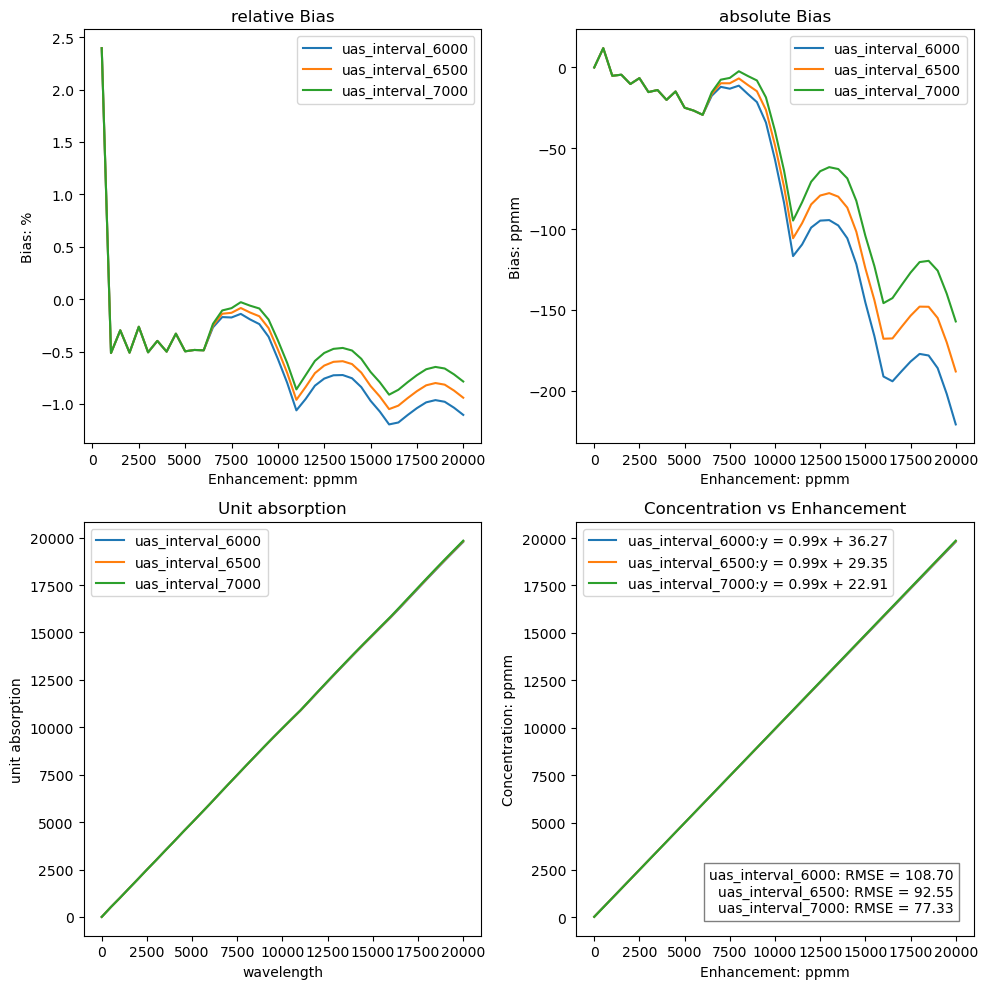

In [33]:
def profile_ml_matched_filter(
    base_array: np.ndarray,
    data_array: np.ndarray,
    unit_absorption_spectrum_array: np.ndarray,
    threshold_list,
):
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array

    target_spectrum = background_spectrum * unit_absorption_spectrum_array[0]
    concentration, _, _, _ = np.linalg.lstsq(
        target_spectrum[:, np.newaxis], (data_array - background_spectrum), rcond=None
    )

    threshold = threshold_list[0]
    i = 1
    while( concentration[0] > threshold and threshold < 50000):
        background_spectrum = background_spectrum + threshold_list[i-1] * target_spectrum
        target_spectrum = (
            background_spectrum * unit_absorption_spectrum_array[i]
        )
        concentration, _, _, _ = np.linalg.lstsq(
            target_spectrum[:, np.newaxis],
            (data_array - background_spectrum),
            rcond=None,
        )
        concentration[0] = concentration[0] + threshold
        threshold += threshold_list[i]
        i += 1
    return concentration[0]


def spectrum_level_test2():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """
    # 可视化
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]
    # 筛选不同的单位吸收光谱 间隔
    ml_rmse_list = []
    for interval in range(6000, 7500, 500):
        # 读取多级单位吸收光谱,并存储在列表中
        uaslist = [] 
        # threshold_list = [1000,1000,1000,1000,1000]
        threshold_list = []
        uasrange = np.arange(0,6000,1000)
        # uasrange = np.array([0,1000,2000,3000,4000,5000])
        for i in uasrange:
            _, uas = glut.generate_satellite_uas_for_specific_range_from_lut(
                "AHSI", i, i + 1000, 2150, 2500, 25, 0
            )
            threshold_list.append(1000)
            uaslist.append(uas)
        uasrange = np.arange(6000, 30000, 5000)
        for i in uasrange:
            # ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
            # _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
            _, uas = glut.generate_satellite_uas_for_specific_range_from_lut(
                "AHSI", i, i + interval, 2150, 2500, 25, 0
            )
            uaslist.append(uas)
            threshold_list.append(5000)
        uas_list = np.array(uaslist)

        # 读取背景光谱
        wvls, base_radiance = glut.get_satellite_radiance_spectrum_from_lut(
            "AHSI", 0, 25, 0, 2150,2500
        )

        # 设置浓度增强范围，并读取对应的radiance光谱
        enhancements = np.arange(0, 20500, 500)
        wvls, radiance_list = glut.batch_get_radiance_from_lut(
            "AHSI", enhancements, 25, 0,2150, 2500
        )
        
        # 拟合甲烷浓度增强
        concentrationlist = []

        for i in range(radiance_list.shape[0]):
            concentration = profile_ml_matched_filter(
                base_radiance, radiance_list[i, :], uas_list, threshold_list
            )
            concentrationlist.append(concentration)
        concentrationlist = np.array(concentrationlist)

        # 计算相对误差和绝对误差
        ml_relative_bias_lists = (concentrationlist - enhancements)*100/ enhancements
        ml_absolute_bias_lists = concentrationlist - enhancements

        # 绘制相对误差和绝对误差的关系图
        ax1.plot(enhancements, ml_relative_bias_lists, label=f"uas_interval_{interval}")
        ax2.plot(enhancements, ml_absolute_bias_lists, label=f"uas_interval_{interval}")
        ax3.plot(enhancements,concentrationlist, label=f"uas_interval_{interval}" )
        # 拟合浓度增强和反演结果之间的线性关系并绘制为图
        polyfit_plot(enhancements, concentrationlist, ax4, f"uas_interval_{interval}")
        
        ml_rmse = np.sqrt(mse(np.array(ml_absolute_bias_lists),np.zeros_like(ml_absolute_bias_lists)))
        ml_rmse_list.append(ml_rmse)

    # 在图中添加 RMSE 注释框
    interval=np.arange(6000, 7500, 500)
    ax4.text(
        0.95,
        0.05,
        f"uas_interval_{interval[0]}: RMSE = {ml_rmse_list[0]:.2f}"+
        f"\nuas_interval_{interval[1]}: RMSE = {ml_rmse_list[1]:.2f}"+
        f"\nuas_interval_{interval[2]}: RMSE = {ml_rmse_list[2]:.2f}",
        transform=ax4.transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    
    # 添加注记等信息
    set_plot_details(ax1, "relative Bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute Bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Unit absorption", "wavelength", "unit absorption")
    set_plot_details(
        ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm"
    )

    plt.tight_layout()
    plt.show()

    return ml_relative_bias_lists, ml_absolute_bias_lists


ml_biaslists, ml_difflists = spectrum_level_test2()


### 两种方式进行对比
选出最佳的参数对前两种方式中进行对比

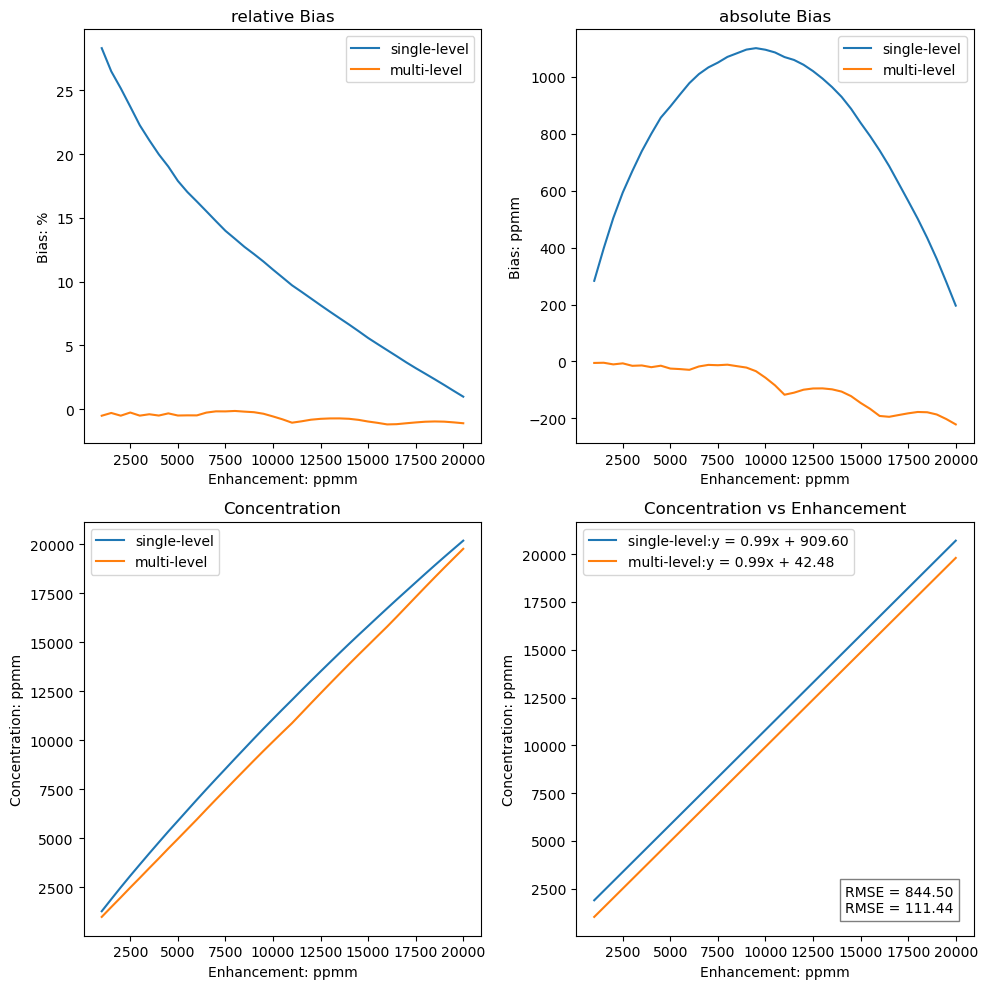

In [19]:

def spectrum_level_test3():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """
    # 读取单层单位吸收光谱    
    _,base_uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0,40000, 2150, 2500, 25, 0)

    # 读取多级单位吸收光谱,并存储在列表中
    uaslist = [] 
    # threshold_list = [1000,1000,1000,1000,1000]
    threshold_list = []
    uasrange = np.arange(0,6000,1000)
    # uasrange = np.array([0,1000,2000,3000,4000,5000])
    for i in uasrange:
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut(
            "AHSI", i, i + 1000, 2150, 2500, 25, 0
        )
        threshold_list.append(1000)
        uaslist.append(uas)
    uasrange = np.arange(6000, 30000, 5000)
    for i in uasrange:
        # ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
        # _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut(
            "AHSI", i, i + 6000, 2150, 2500, 25, 0
        )
        uaslist.append(uas)
        threshold_list.append(5000)
    uas_list = np.array(uaslist)
    
    # 读取背景光谱
    _,base_radiance = glut.get_satellite_radiance_spectrum_from_lut("AHSI",0,25,0,2150,2500)
    
    # initiatate variables
    sg_concentrationlist = []
    sg_biaslists = []
    sg_difflists = []
    
    ml_concentrationlist = []
    ml_biaslists = []
    ml_difflists = []
    
    # 拟合甲烷浓度增强
    enhancements = np.arange(1000,20500,500)
    for enhancement in enhancements:
        # 读取模拟辐射数据
        wvls,radiance = glut.get_satellite_radiance_spectrum_from_lut("AHSI",enhancement,25,0,2150,2500)
        # 计算甲烷浓度增强，并计算与实际值的偏差
        concentration = profile_matched_filter(base_radiance,radiance,base_uas)
        sg_biaslists.append(((concentration-enhancement)*100/enhancement))
        sg_difflists.append(concentration-enhancement)
        sg_concentrationlist.append(concentration)
        
        concentration = profile_ml_matched_filter(base_radiance,radiance,uas_list,threshold_list)
        ml_biaslists.append(((concentration-enhancement)*100/enhancement))
        ml_difflists.append(concentration-enhancement)
        ml_concentrationlist.append(concentration)
    
    # 可视化
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax[0,0],ax[0,1],ax[1,0],ax[1,1]
    
    ax1.plot(enhancements,sg_biaslists,label="single-level")
    ax1.plot(enhancements,ml_biaslists,label="multi-level")
    ax2.plot(enhancements,sg_difflists,label="single-level")
    ax2.plot(enhancements,ml_difflists,label="multi-level")
    ax3.plot(enhancements,sg_concentrationlist,label="single-level")
    ax3.plot(enhancements,ml_concentrationlist,label="multi-level")
    polyfit_plot(enhancements,sg_concentrationlist,ax4,"single-level")
    polyfit_plot(enhancements,ml_concentrationlist,ax4,"multi-level")
    
    set_plot_details(ax1, "relative Bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute Bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Concentration", "Enhancement: ppmm", "Concentration: ppmm")
    set_plot_details(ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm")
    
    sg_rmse = np.sqrt(mse(np.array(sg_difflists),np.zeros_like(sg_difflists)))
    ml_rmse = np.sqrt(mse(np.array(ml_difflists),np.zeros_like(ml_difflists)))
    # 在图中添加 RMSE 注释框
    ax4.text(
        0.95,
        0.05,
        f"RMSE = {sg_rmse:.2f}"+
          f"\nRMSE = {ml_rmse:.2f}",
        transform=ax4.transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    plt.tight_layout()
    plt.show()
    
    return sg_biaslists,ml_biaslists

ml_biaslists,sg_biaslists = spectrum_level_test3()

## 模拟影像测试_1(背景光谱已知)
此测试针对 受到 uniformly random分布的 2% 像素的甲烷浓度增强的模拟影像，背景光谱已知，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

In [10]:

def matched_filter_with_fixed_bg(
    base_array: np.ndarray, data_array: np.ndarray, unit_absorption_spectrum: np.ndarray
):
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands, rows, cols = data_array.shape
    concentration = np.zeros((rows, cols))

    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum * unit_absorption_spectrum
    radiancediff_with_back = data_array - background_spectrum[:, np.newaxis, np.newaxis]

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands, bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:, i, j], d_covariance[:, i, j])
    covariance /= rows * cols
    covariance_inverse = np.linalg.pinv(covariance)

    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = (
                radiancediff_with_back[:, i, j].T @ covariance_inverse @ target_spectrum
            )
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i, j] = up / down

    return concentration


def ml_matched_filter_with_fixed_bg(
    base_array: np.ndarray,
    data_array: np.ndarray,
    unit_absorption_spectrum_array: np.ndarray,
):
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands, rows, cols = data_array.shape
    concentration = np.zeros((rows, cols))

    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum * unit_absorption_spectrum_array[0]
    radiancediff_with_back = data_array - background_spectrum[:, np.newaxis, np.newaxis]

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands, bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:, i, j], d_covariance[:, i, j])
    covariance /= rows * cols
    covariance_inverse = np.linalg.inv(covariance)

    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = (
                radiancediff_with_back[:, i, j].T @ covariance_inverse @ target_spectrum
            )
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i, j] = up / down

    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000 * target_spectrum
    target_spectrum = background_spectrum * unit_absorption_spectrum_array[1]
    radiancediff_with_back = data_array - background_spectrum[:, np.newaxis, np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i, j] > 4000:
                up = (
                    radiancediff_with_back[:, i, j].T
                    @ covariance_inverse
                    @ target_spectrum
                )
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i, j] = up / down + 4000

    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000 * target_spectrum
    target_spectrum = background_spectrum * unit_absorption_spectrum_array[2]
    radiancediff_with_back = data_array - background_spectrum[:, np.newaxis, np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i, j] > 8000:
                up = (
                    radiancediff_with_back[:, i, j].T
                    @ covariance_inverse
                    @ target_spectrum
                )
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i, j] = up / down + 8000

    background_spectrum = background_spectrum + 4000 * target_spectrum
    target_spectrum = background_spectrum * unit_absorption_spectrum_array[3]
    radiancediff_with_back = data_array - background_spectrum[:, np.newaxis, np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i, j] > 12000:
                up = (
                    radiancediff_with_back[:, i, j].T
                    @ covariance_inverse
                    @ target_spectrum
                )
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i, j] = up / down + 12000

    background_spectrum = background_spectrum + 4000 * target_spectrum
    target_spectrum = background_spectrum * unit_absorption_spectrum_array[4]
    radiancediff_with_back = data_array - background_spectrum[:, np.newaxis, np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i, j] > 16000:
                up = (
                    radiancediff_with_back[:, i, j].T
                    @ covariance_inverse
                    @ target_spectrum
                )
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i, j] = up / down + 16000

    return concentration


def enhancement_2perc():
    """
    对影像的2%像素施加随机浓度增强，增强值在0-20000ppmm范围内，遵循均匀分布。
    """
    np.random.seed(42)  # 保证每次生成相同的随机数
    matrix_size = 200
    num_pixels = matrix_size * matrix_size
    num_enhanced_pixels = int(0.02 * num_pixels)  # 2%的像素

    # 随机选择2%的像素索引
    indices = np.random.choice(num_pixels, num_enhanced_pixels, replace=False)

    # 生成浓度增强值，遵循均匀分布，范围在 0-20000 ppmm
    random_enhancement_values = np.random.uniform(0, 20000, num_enhanced_pixels)

    # 创建一个初始为零的矩阵，并在选定的索引位置施加随机增强值
    plume = np.zeros((matrix_size, matrix_size))
    np.put(plume, indices, random_enhancement_values)

    # 选取未增强的像素，并将索引转换为行列索引
    all_indices = np.arange(plume.size)
    unenhanced_indices = np.setdiff1d(all_indices, indices)
    enhanced_mask = np.unravel_index(indices, (matrix_size, matrix_size))
    unenhanced_mask = np.unravel_index(unenhanced_indices, (matrix_size, matrix_size))

    # 生成模拟影像
    simulated_image = si.simulate_satellite_images_with_plume("AHSI",plume,25,0,2150,2500,0.01)
    return simulated_image, enhanced_mask, unenhanced_mask, random_enhancement_values


### 常规匹配滤波算法

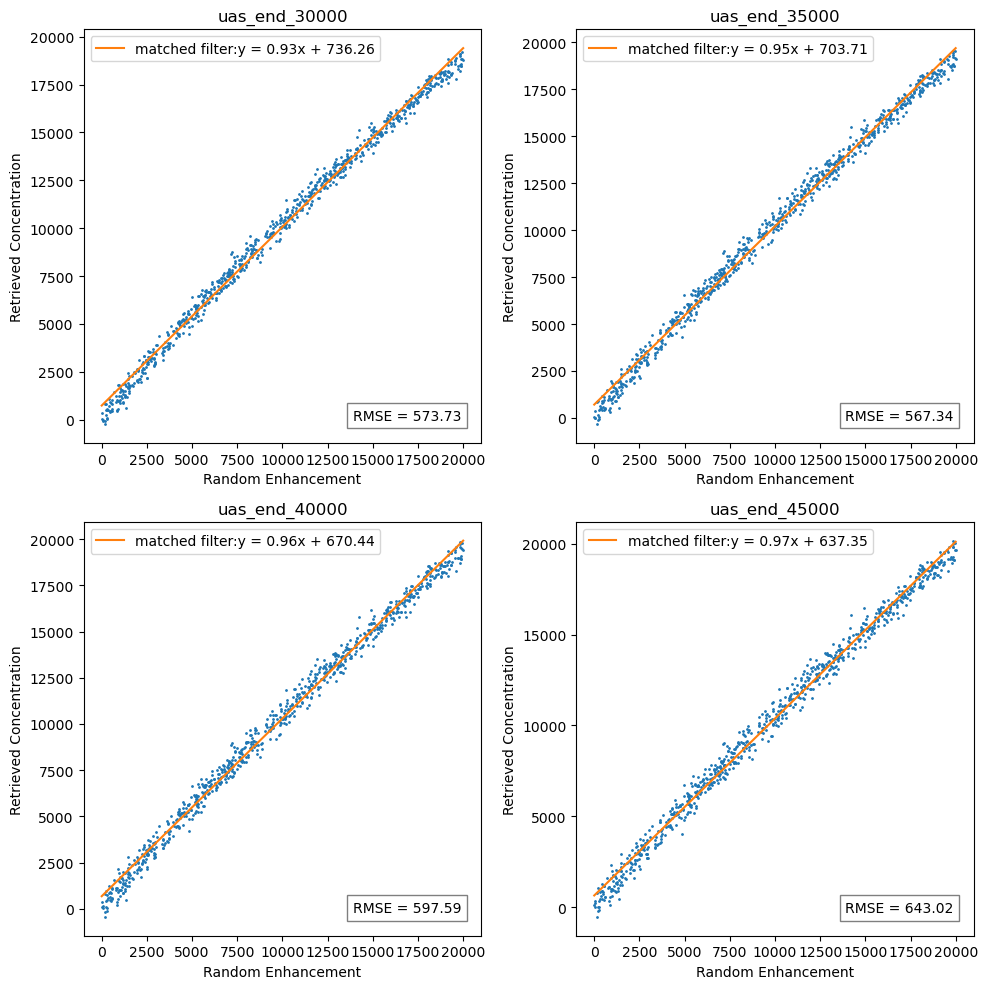

In [23]:
def image_level_test2_1():
    """
    测试随机 2% 像素的随机浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或参数，并绘制浓度曲线图和 bias 曲线图。
    """
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    axf = ax.flatten()
    i = 0

    # 循环不同的uas范围
    for end in range(30000, 50000, 5000):
        ax1 = axf[i]

        # 读取 AHSI 单位吸收谱
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, end, 2150, 2500, 25, 0)

        # 读取背景光谱
        # basefilepath = "C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        # channels_path = (
        #     "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        # )
        
        wvls, base_radiance = glut.get_satellite_radiance_spectrum_from_lut("AHSI",0,25,0,2150,2500)

        resultlist = []

        # 生成随机浓度增强的模拟影像
        simulated_image, enhanced_mask,_, random_enhancement_values = (
            enhancement_2perc()
        )

        # 使用匹配滤波算法计算浓度增强
        result = matched_filter_with_fixed_bg(base_radiance, simulated_image, uas)

        # 计算增强和未增强像素的平均浓度
        enhanced = result[enhanced_mask]
        # unenhanced = result[unenhanced_mask]

        # 保存每次模拟的增强像素的平均浓度值
        resultlist.append(np.mean(enhanced))

        # 绘制散点图，x轴为随机生成的增强浓度，y轴为计算得到的浓度值
        ax1.plot(
            random_enhancement_values,
            enhanced,
            marker="o",
            markersize=1,
            linestyle="None",
        )

        # 绘制拟合线
        polyfit_plot(random_enhancement_values, enhanced, ax1, "matched filter")
        set_plot_details(
            ax1, f"uas_end_{end}", "Random Enhancement", "Retrieved Concentration"
        )
        rmse = np.sqrt(mse(random_enhancement_values,enhanced))
        # 在图中添加 RMSE 注释框
        ax1.text(
            0.95,
            0.05,
            f"RMSE = {rmse:.2f}",
            transform=ax1.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="right",
            bbox=dict(facecolor="white", alpha=0.5),
        )
        i += 1

    # 布局调整和显示
    plt.tight_layout()
    plt.show()

    return None


image_level_test2_1()

### 多层匹配滤波算法

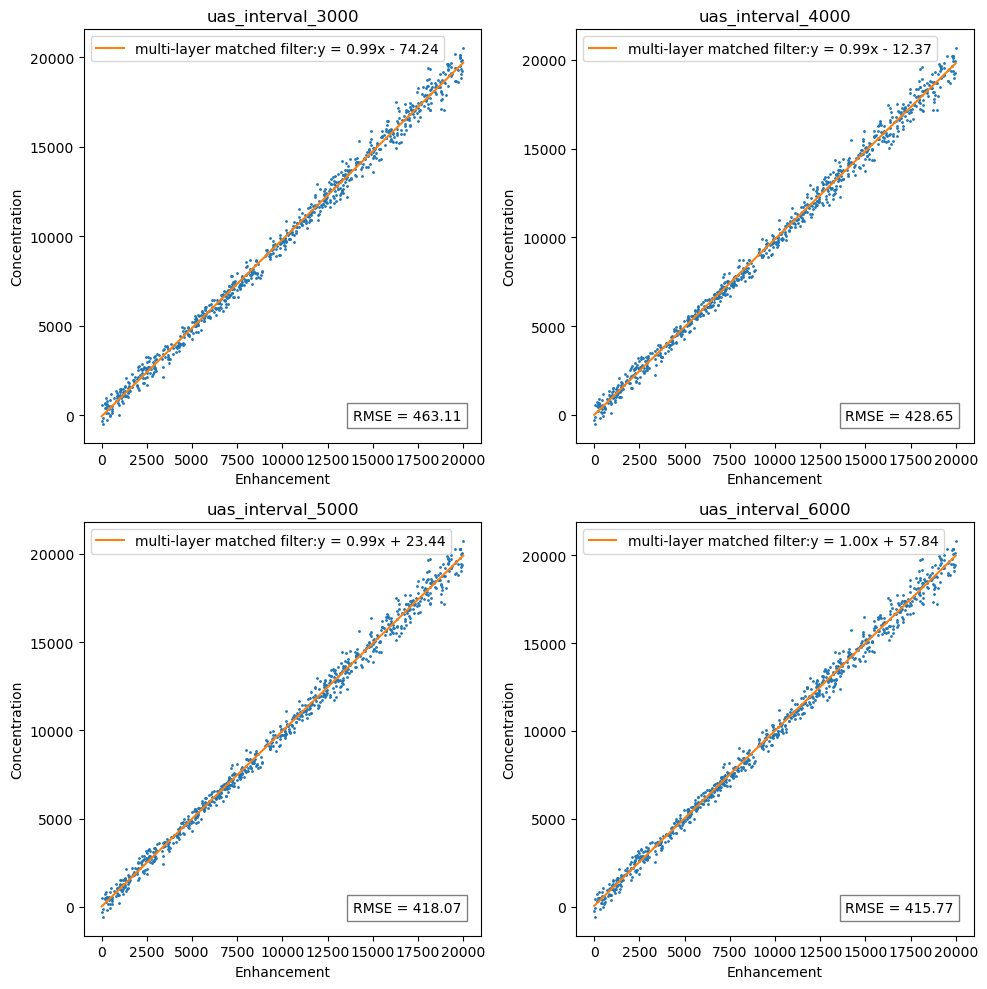

In [25]:
def image_level_test2_2():
    """
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用多层匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    # 读取背景光谱
    
    _, base_radiance = glut.get_satellite_radiance_spectrum_from_lut("AHSI", 0, 25, 0, 2150, 2500)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    axf = ax.flatten()
    axindex = 0
    for interval in range(3000, 7000, 1000):
        # 读取 AHSI 单位吸收谱
        uaslist = []
        _,uas = glut.generate_satellite_uas_for_specific_range_from_lut(
            "AHSI", 0,46000, 2150, 2500, 25, 0
        )
        uasrange = np.arange(0, 46000, 4000)
        for i in uasrange:
            _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", i, i + interval, 2150, 2500, 25, 0)
            uaslist.append(uas)

        ax1 = axf[axindex]
        resultlist = []

        simulated_image, enhanced_mask, unenhanced_mask, random_enhancement_values = (
            enhancement_2perc()
        )
        # 使用匹配滤波算法计算浓度增强
        result = ml_matched_filter_with_fixed_bg(
            base_radiance, simulated_image, uaslist
        )
        enhanced = result[enhanced_mask]

        ax1.plot(
            random_enhancement_values,
            enhanced,
            marker="o",
            markersize=1,
            linestyle="None",
        )
        polyfit_plot(
            random_enhancement_values, enhanced, ax1, "multi-layer matched filter"
        )
        set_plot_details(
            ax1, f"uas_interval_{interval}", "Enhancement", "Concentration"
        )
        rmse = np.sqrt(mse(random_enhancement_values,enhanced))
        # 在图中添加 RMSE 注释框
        ax1.text(
            0.95,
            0.05,
            f"RMSE = {rmse:.2f}",
            transform=ax1.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="right",
            bbox=dict(facecolor="white", alpha=0.5),
        )
        axindex += 1
    plt.tight_layout()
    plt.show()

    return resultlist


resultlist = image_level_test2_2()

### 两种算法进行对比

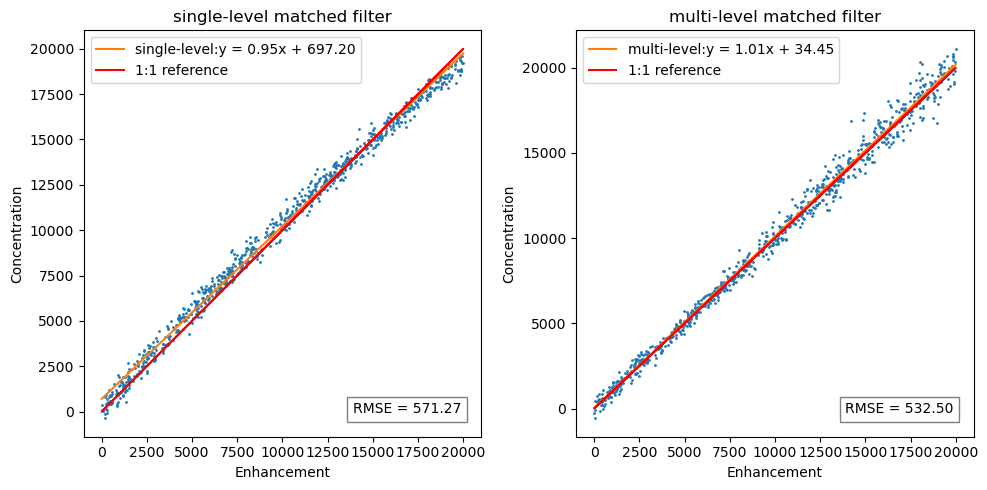

In [28]:
def image_level_test2_12():
    """
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    resultlist1 = []
    resultlist2 = []

    _, base_radiance = glut.get_satellite_radiance_spectrum_from_lut("AHSI",0,25,0,2150,2500)

    # 读取 AHSI 单位吸收谱
    _,base_uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",0,36000,2150,2500,25,0)

    # 读取多层单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(0, 44000, 6000)
    for i in uasrange:
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",i,i+6000,2150,2500,25,0)
        uaslist.append(uas)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    simulated_image, enhanced_mask, unenhanced_mask, random_enhancement_values = (
        enhancement_2perc()
    )

    # 使用匹配滤波算法计算浓度增强
    result = matched_filter_with_fixed_bg(base_radiance, simulated_image, base_uas)
    enhanced = result[enhanced_mask]
    unenhanced = result[unenhanced_mask]
    ax[0].plot(
        random_enhancement_values, enhanced, marker="o", markersize=1, linestyle="None"
    )
    polyfit_plot(random_enhancement_values, enhanced, ax[0], "single-level")
    rmse = np.sqrt(mse(random_enhancement_values,enhanced))
    # 在图中添加 RMSE 注释框
    ax[0].text(
        0.95,
        0.05,
        f"RMSE = {rmse:.2f}",
        transform=ax[0].transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    # 使用多层单位吸收光谱匹配滤波算法计算浓度增强
    result = ml_matched_filter_with_fixed_bg(base_radiance, simulated_image, uaslist)
    enhanced = result[enhanced_mask]

    ax[1].plot(
        random_enhancement_values, enhanced, marker="o", markersize=1, linestyle="None"
    )
    polyfit_plot(random_enhancement_values, enhanced, ax[1], "multi-level")
    rmse = np.sqrt(mse(random_enhancement_values,enhanced))
    # 在图中添加 RMSE 注释框
    ax[1].text(
        0.95,
        0.05,
        f"RMSE = {rmse:.2f}",
        transform=ax[1].transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    
    ax[0].plot(
        random_enhancement_values,
        random_enhancement_values,
        label="1:1 reference",
        color="red",
    )
    
    ax[1].plot(
        random_enhancement_values,
        random_enhancement_values,
        label="1:1 reference",
        color="red",
    )
    
    set_plot_details(
        ax[0], "single-level matched filter", "Enhancement", "Concentration"
    )
    set_plot_details(
        ax[1], "multi-level matched filter", "Enhancement", "Concentration"
    )
    
    plt.tight_layout()
    plt.show()
    return resultlist1, resultlist2


resultlist1, resultlist2 = image_level_test2_12()

## 模拟影像测试_2(背景光谱未知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱未知，需要近似和不断修正，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

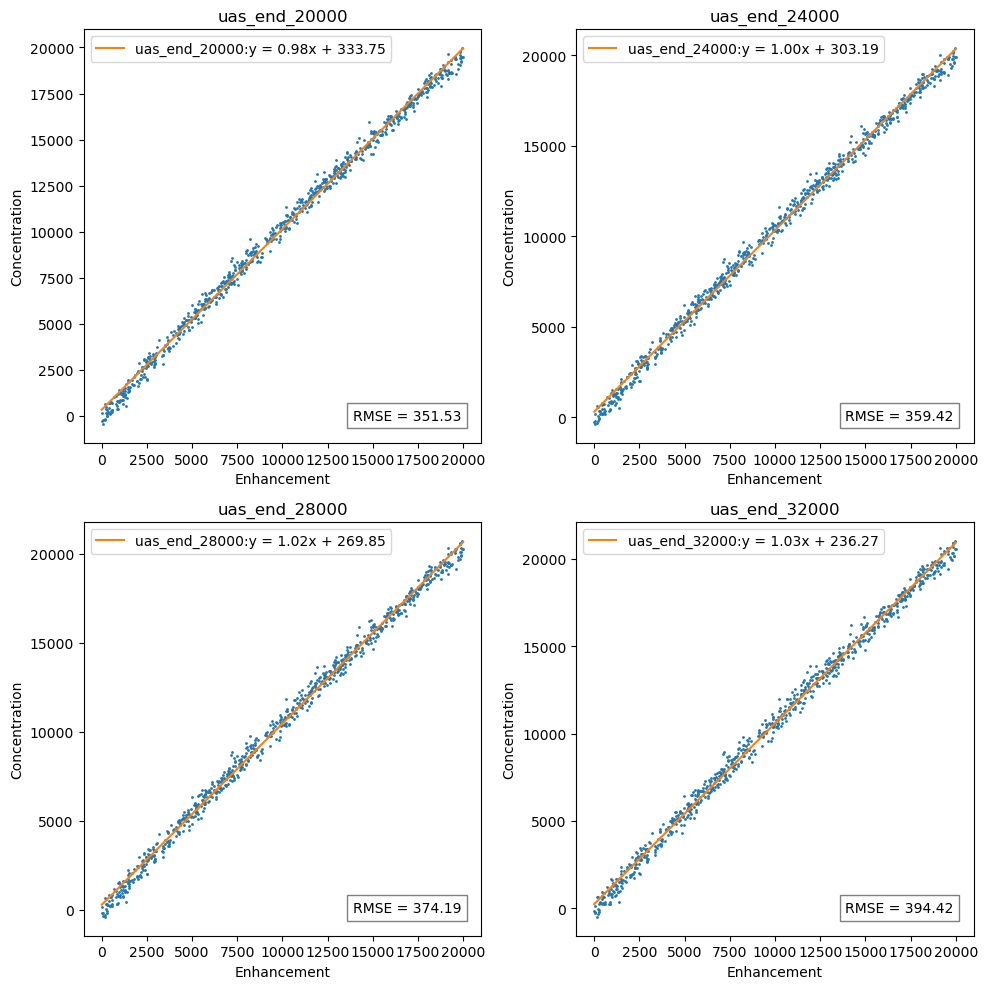

In [29]:
def image_level_test2_3():
    """
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    使用不同的单位吸收光谱
    """
    # 读取 AHSI 单位吸收谱
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axf = axes.flatten()
    axindex = 0
    for end in range(20000, 33000, 4000):
        ax = axf[axindex]
        # 读取单位吸收光谱
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, end, 2150, 2500, 25, 0)

        simulated_image, enhanced_mask, unenhanced_mask, random_enhancement_values = (
            enhancement_2perc()
        )
        result = mfs.matched_filter(
            simulated_image, uas, iterate=False, albedoadjust=True
        )
        enhanced = result[enhanced_mask]
        ax.plot(
            random_enhancement_values,
            enhanced,
            marker="o",
            markersize=1,
            linestyle="None",
        )
        polyfit_plot(random_enhancement_values, enhanced, ax, f"uas_end_{end}")

        # 计算 RMSE
        slope, intercept = np.polyfit(random_enhancement_values, enhanced, 1)
        predicted = slope * random_enhancement_values + intercept
        rmse = np.sqrt(mse(enhanced, predicted))

        # 在图中添加 RMSE 注释框
        ax.text(
            0.95,
            0.05,
            f"RMSE = {rmse:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="right",
            bbox=dict(facecolor="white", alpha=0.5),
        )
        set_plot_details(ax, f"uas_end_{end}", "Enhancement", "Concentration")
        axindex += 1

    plt.tight_layout()
    plt.show()

    return None


image_level_test2_3()

### 多层匹配滤波算法

Iteration 3: Converged with std change 33.79492692283793.
Iteration 3: Converged with std change 33.79492692283793.
Iteration 3: Converged with std change 33.79492692283793.
Iteration 3: Converged with std change 33.79492692283793.


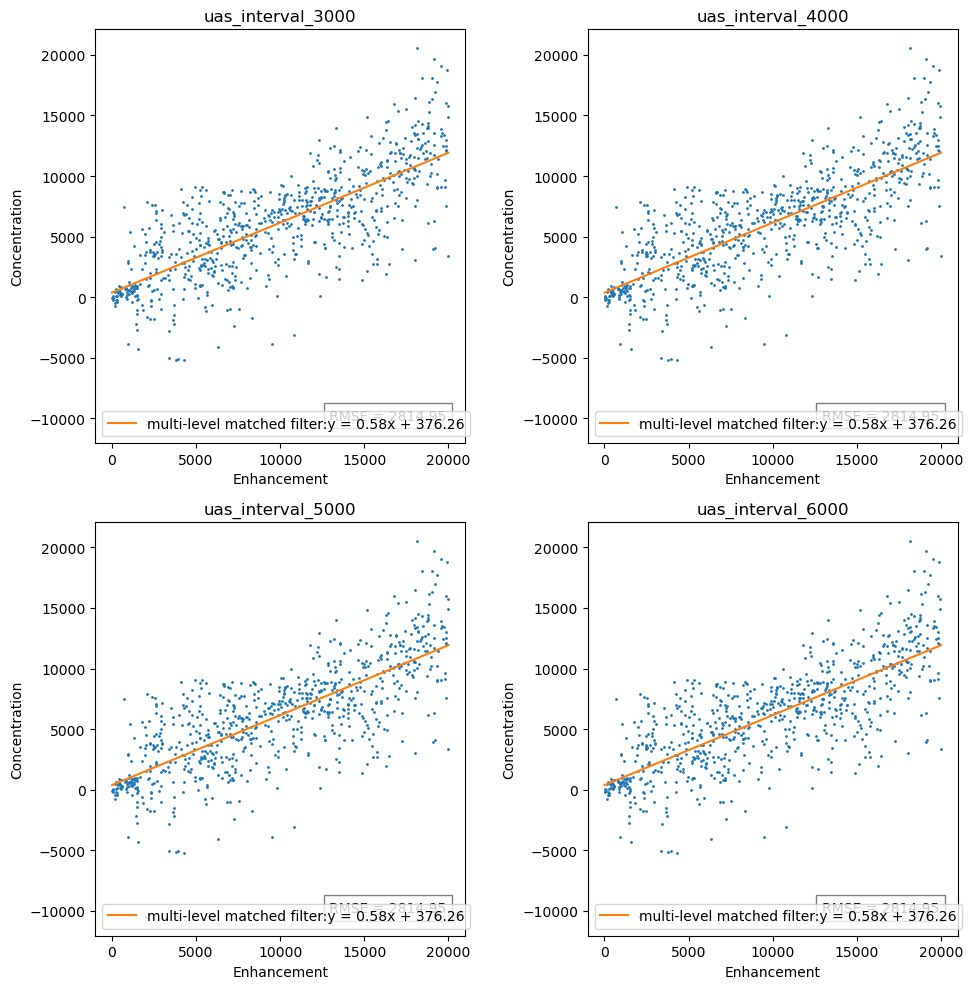

In [11]:
def image_level_test2_4():
    """
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    ax = axes[0]
    # 读取单位吸收光谱列表
    uaslist = []
    resultlist = []
    _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, 50000, 2150, 2500, 25, 0)
    uaslist.append(uas)

    simulated_image, enhanced_mask, unenhanced_mask, random_enhancement_values = (
        enhancement_2perc()
    )
    # result = mfs.ml_matched_filter_new("AHSI",simulated_image, uaslist, False)
    result = mfa.ml_matched_filter(simulated_image, uaslist[0])

    enhanced = result[enhanced_mask]
    resultlist.append(np.mean(enhanced))
    ax.plot(
        random_enhancement_values,
        enhanced,
        marker="o",
        markersize=1,
        linestyle="None",
    )
    polyfit_plot(
        random_enhancement_values, enhanced, ax, "multi-level matched filter"
    )

    # 计算 RMSE
    slope, intercept = np.polyfit(random_enhancement_values, enhanced, 1)
    predicted = slope * random_enhancement_values + intercept
    rmse = np.sqrt(mse(enhanced, predicted))

    # 在图中添加 RMSE 注释框
    ax.text(
        0.95,
        0.05,
        f"RMSE = {rmse:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    set_plot_details(ax, "multi-layer matched_filter", "Enhancement", "Concentration")

    plt.tight_layout()
    plt.show()
    return None

image_level_test2_4()

### 两种算法对比
基于前两个测试的最佳参数，对两者的反演结果进行对比。

In [4]:
from algorithms.matched_filter_variants import matched_filter, ml_matched_filter


def image_level_test2_34():
    """
    测试随机 2% 像素的统一浓度的甲烷浓度增强的反演结果
    背景光谱未知，使用多层的单位吸收光谱
    并拟合出浓度增强与实际浓度增强的关系，
    """
    resultlist = []  # 初始化空列表
    resultlist2 = []  # 初始化空列表

    # 读取背景光谱
    uas_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _, general_uas = gf.open_unit_absorption_spectrum(uas_path, 2150, 2500)

    # 读取多层单位吸收光谱,并存储在列表中
    uaslist = []
    uaslist.append(general_uas)
    uasrange = np.arange(6000, 46000, 6000)
    for i in uasrange:
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", i, i + 6000, 2150, 2500, 25, 0)
        uaslist.append(uas)

    # 可视化
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax1, ax2 = ax[0], ax[1]

    # 生成不同浓度增强的模拟影像，并计算浓度增强
    simulated_image, enhanced_mask, unenhanced_mask, random_enhancement_values = (
        enhancement_2perc()
    )

    # 使用匹配滤波算法计算浓度增强
    result = matched_filter(simulated_image, general_uas, True, True, False)
    enhanced = result[enhanced_mask]
    resultlist.append(np.mean(enhanced))
    ax1.plot(
        random_enhancement_values, enhanced, marker="o", markersize=1, linestyle="None"
    )
    polyfit_plot(
        random_enhancement_values, enhanced, ax1, "matched filter | uas_end_36000"
    )

    # 计算 RMSE
    slope, intercept = np.polyfit(random_enhancement_values, enhanced, 1)
    predicted = slope * random_enhancement_values + intercept
    rmse = np.sqrt(mse(enhanced, predicted))

    # 在 ax1 图中添加 RMSE 注释框
    ax1.text(
        0.95,
        0.05,
        f"RMSE = {rmse:.2f}",
        transform=ax1.transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # 使用多层匹配滤波计算浓度增强
    _, result = mfa.ml_matched_filter(simulated_image, general_uas)
    enhanced = result[enhanced_mask]
    resultlist2.append(np.mean(enhanced))
    ax2.plot(
        random_enhancement_values, enhanced, marker="o", markersize=1, linestyle="None"
    )
    polyfit_plot(random_enhancement_values, enhanced, ax2, "ML matched filter")

    # 计算 RMSE
    slope, intercept = np.polyfit(random_enhancement_values, enhanced, 1)
    predicted = slope * random_enhancement_values + intercept
    rmse = np.sqrt(mse(enhanced, predicted))

    # 在 ax2 图中添加 RMSE 注释框
    ax2.text(
        0.95,
        0.05,
        f"RMSE = {rmse:.2f}",
        transform=ax2.transAxes,
        fontsize=10,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    set_plot_details(ax1, "matched filter", "Enhancement", "Concentration")
    set_plot_details(ax2, "ML matched filter", "Enhancement", "Concentration")

    plt.tight_layout()
    plt.show()

    return resultlist, resultlist2


# 运行修改后的函数
resultlist, resultlist2 = image_level_test2_34()

Error: The file 'C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt' was not found.


TypeError: cannot unpack non-iterable NoneType object

## 模拟影像测试_2(无烟羽)



### 多层匹配滤波算法

No significant plume detected.
反演结果均值: 0.00
反演结果标准差: 1488.16
反演结果最小值: -6248.82
反演结果最大值: 6339.69
反演结果中位数: 10.84


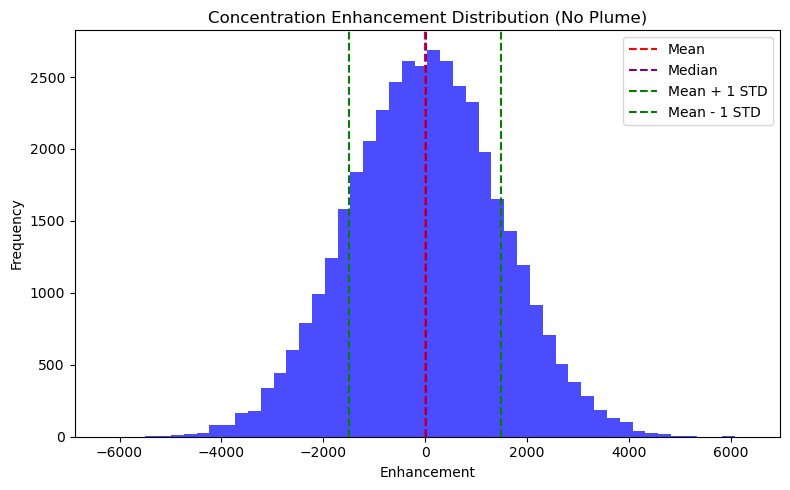

In [8]:
def image_level_test3_2():
    """
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取无烟羽的模拟影像
    simulated_image = si.simulate_satellite_images_without_plume("AHSI", (200,200),25, 0, 2150, 2500,0.01)

    # 读取单位吸收光谱列表
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    uaslist = []
    _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, 50000, 2150, 2500, 25, 0)
    uaslist.append(uas)  # 假设 uaslist 的第一个元素即为所需的单位吸收光谱

    # 进行浓度反演
    enhancement = mfa.ml_matched_filter(simulated_image, uaslist[0])
    
    # Step 1: 计算统计参数
    mean_enhancement = np.mean(enhancement)
    std_enhancement = np.std(enhancement)
    min_enhancement = np.min(enhancement)
    max_enhancement = np.max(enhancement)
    median_enhancement = np.median(enhancement)
    
    # 打印统计结果
    print(f"反演结果均值: {mean_enhancement:.2f}")
    print(f"反演结果标准差: {std_enhancement:.2f}")
    print(f"反演结果最小值: {min_enhancement:.2f}")
    print(f"反演结果最大值: {max_enhancement:.2f}")
    print(f"反演结果中位数: {median_enhancement:.2f}")
    
    # Step 2: 可视化反演结果分布
    # 绘制浓度分布的直方图
    ax.hist(enhancement.flatten(), bins=50, color='blue', alpha=0.7)
    ax.axvline(mean_enhancement, color='red', linestyle='--', label='Mean')
    ax.axvline(median_enhancement, color='purple', linestyle='--', label='Median')
    ax.axvline(mean_enhancement + std_enhancement, color='green', linestyle='--', label='Mean + 1 STD')
    ax.axvline(mean_enhancement - std_enhancement, color='green', linestyle='--', label='Mean - 1 STD')
    ax.set_title("Concentration Enhancement Distribution (No Plume)")
    ax.set_xlabel("Enhancement")
    ax.set_ylabel("Frequency")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return None

    

image_level_test3_2()

## 模拟影像测试_3(高斯烟羽)
此测试针对 叠加了高斯烟羽甲烷浓度增强分布的模拟影像，背景光谱未知，需要通过近似和修正来贴近真实背景光谱
使用不同的匹配滤波算法进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

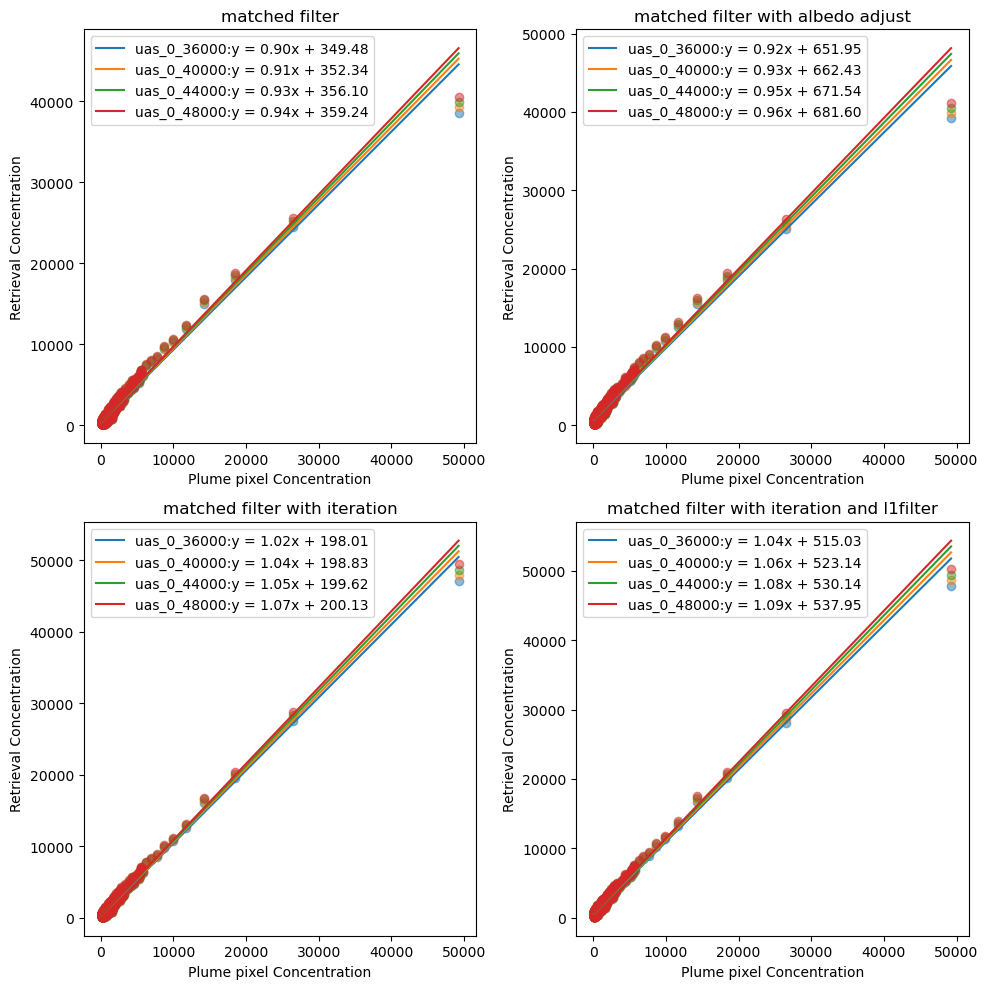

In [11]:
def image_level_test3_1():
    """
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 加载烟羽和叠加烟羽的模拟影像
    plume_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\simulated_plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = si.simulate_satellite_images_with_plume("AHSI", plume, 25,0,2150,2500, 0.01)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    sub_function(plume, simulated_image, ax1, False, False)
    sub_function(plume, simulated_image, ax2, True, False)
    sub_function(plume, simulated_image, ax3, False, True)
    sub_function(plume, simulated_image, ax4, True, True)
    set_plot_details(
        ax1, "matched filter", "Plume pixel Concentration", "Retrieval Concentration"
    )
    set_plot_details(
        ax2,
        "matched filter with albedo adjust",
        "Plume pixel Concentration",
        "Retrieval Concentration",
    )
    set_plot_details(
        ax3,
        "matched filter with iteration",
        "Plume pixel Concentration",
        "Retrieval Concentration",
    )
    set_plot_details(
        ax4,
        "matched filter with iteration and l1filter",
        "Plume pixel Concentration",
        "Retrieval Concentration",
    )

    plt.tight_layout()
    plt.show()

    return None


def sub_function(plume, simulated_image, ax, *args):
    for end in range(36000, 50000, 4000):
        # 加载单位吸收谱并生成匹配滤波算法的结果
        _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, end, 2150, 2500, 25, 0)
        enhancement = mfs.matched_filter(simulated_image, uas, *args)

        plume_mask = plume > 100
        result_mask = enhancement > 100
        total_mask = plume_mask * result_mask

        # 可视化
        ax.scatter(plume[total_mask], enhancement[total_mask], alpha=0.5)
        polyfit_plot(
            plume[total_mask].flatten(),
            enhancement[total_mask].flatten(),
            ax,
            f"uas_0_{end}",
        )
        rmse = np.average(mse(plume[total_mask],enhancement[total_mask]))
        ax.text()

        # # 对烟羽反演结果进行量化
        # molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
        # molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
        # emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
        # retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6


image_level_test3_1()

### 多层匹配滤波算法

Iteration 0: Converged with std change 5.161498877684494.
161510.8824998058
183632.93926489196


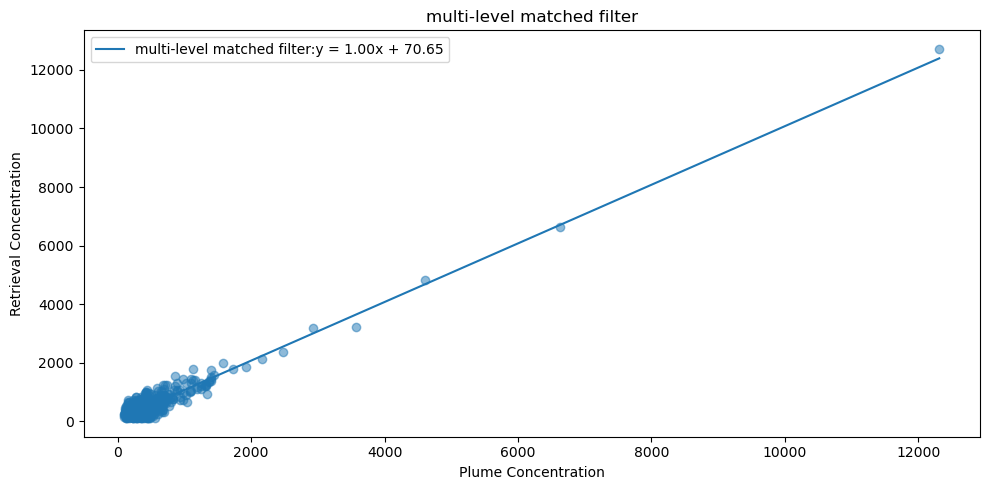

In [3]:
def image_level_test3_2():
    """
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽模型
    plume_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\simulated_plumes\\gaussianplume_1000_8_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = si.simulate_satellite_images_with_plume("AHSI", plume, 25,0,2150, 2500, 0.01)

    # 读取单位吸收光谱列表
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax1 = ax
    uaslist = []
    _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, 50000, 2150, 2500, 25, 0)
    uaslist.append(uas)

    # 加载单位吸收谱并生成匹配滤波算法的结果
    enhancement = mfa.ml_matched_filter(simulated_image,uaslist[0])
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask * result_mask

    # 可视化
    ax.scatter(plume[total_mask], enhancement[total_mask], alpha=0.5)
    polyfit_plot(
        plume[total_mask].flatten(),
        enhancement[total_mask].flatten(),
        ax,
        "multi-level matched filter",
    )

    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = (
        np.sum(plume[total_mask]) * 900 * (molar_mass_CH4 / molar_volume_STP) * 1e-6
    )
    retrieval_emission = (
        np.sum(enhancement[total_mask])
        * 900
        * (molar_mass_CH4 / molar_volume_STP)
        * 1e-6
    )
    print(emission)
    print(retrieval_emission)
    
    set_plot_details(
        ax1,
        "multi-level matched filter",
        "Plume Concentration",
        "Retrieval Concentration",
    )
    
    plt.tight_layout()
    plt.show()

    return None


def sub_function_2(plume, simulated_image, uaslist, ax, *args):
    # 加载单位吸收谱并生成匹配滤波算法的结果
    enhancement = mfa.ml_matched_filter(simulated_image,uaslist[0])
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask * result_mask

    # 可视化
    ax.scatter(plume[total_mask], enhancement[total_mask], alpha=0.5)
    polyfit_plot(
        plume[total_mask].flatten(),
        enhancement[total_mask].flatten(),
        ax,
        "multi-level matched filter",
    )

    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = (
        np.sum(plume[total_mask]) * 900 * (molar_mass_CH4 / molar_volume_STP) * 1e-6
    )
    retrieval_emission = (
        np.sum(enhancement[total_mask])
        * 900
        * (molar_mass_CH4 / molar_volume_STP)
        * 1e-6
    )
    
    return None

image_level_test3_2()

### 两种算法对比

Iteration 0: Converged with std change 13.286210193545173.


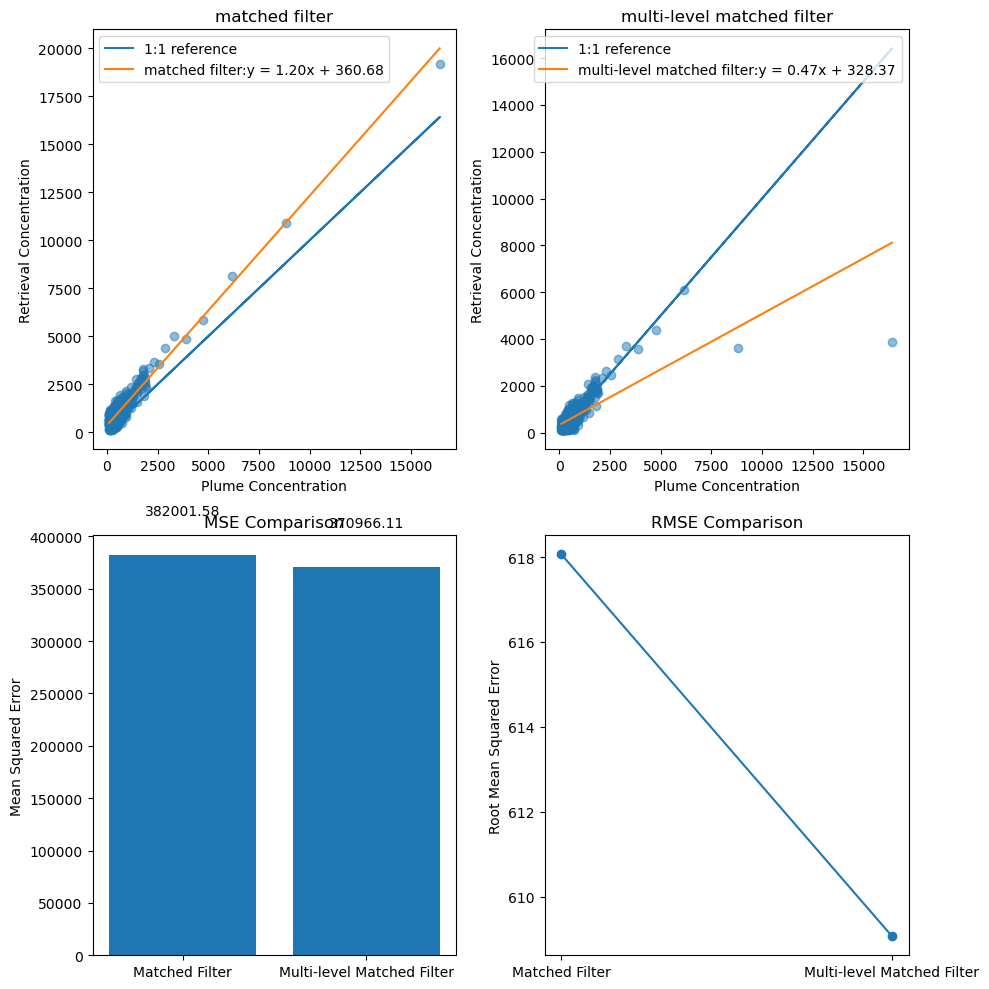

In [4]:
def image_level_test3_3():
    """
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽 以及 叠加了烟羽的模拟影像
    plume_path = "C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src\\data\\simulated_plumes\\gaussianplume_1000_6_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = si.simulate_satellite_images_with_plume("AHSI", plume, 25,0,2150, 2500, 0.01)
    _, general_uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, 50000, 2150, 2500, 25, 0)

    # 读取单位吸收光谱列表
    uaslist = []
    _, uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI", 0, 50000, 2150, 2500, 25, 0)
    uaslist.append(uas)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    enhancement = mfs.matched_filter(simulated_image, general_uas, True, True)
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask * result_mask

    ax1.scatter(plume[total_mask], enhancement[total_mask], alpha=0.5)
    ax1.plot(plume[total_mask], plume[total_mask], label="1:1 reference")
    polyfit_plot(
        plume[total_mask].flatten(),
        enhancement[total_mask].flatten(),
        ax1,
        "matched filter",
    )

    enhancement2 = mfa.ml_matched_filter(simulated_image, uaslist[0])
    plume_mask = plume > 100
    result_mask = enhancement2 > 100
    total_mask = plume_mask * result_mask

    ax2.scatter(plume[total_mask], enhancement2[total_mask], alpha=0.5)
    ax2.plot(plume[total_mask], plume[total_mask], label="1:1 reference")
    polyfit_plot(
        plume[total_mask].flatten(),
        enhancement2[total_mask].flatten(),
        ax2,
        "multi-level matched filter",
    )

    set_plot_details(
        ax1, "matched filter", "Plume Concentration", "Retrieval Concentration"
    )
    set_plot_details(
        ax2,
        "multi-level matched filter",
        "Plume Concentration",
        "Retrieval Concentration",
    )

    # 计算误差
    mse1 = mse(plume[total_mask], enhancement[total_mask])
    mse2 = mse(plume[total_mask], enhancement2[total_mask])

    # 绘制误差条形图
    errors = [mse1, mse2]
    labels = ["Matched Filter", "Multi-level Matched Filter"]
    ax3.bar(labels, errors)
    ax3.set_title("MSE Comparison")
    ax3.set_ylabel("Mean Squared Error")

    # 显示误差值
    for i, v in enumerate(errors):
        ax3.text(i, v + 0.1 * max(errors), f"{v:.2f}", ha="center")

    # RMSE 误差折线图
    rmse1 = np.sqrt(mse1)
    rmse2 = np.sqrt(mse2)
    rmses = [rmse1, rmse2]

    ax4.plot(labels, rmses, marker="o")
    ax4.set_title("RMSE Comparison")
    ax4.set_ylabel("Root Mean Squared Error")

    plt.tight_layout()
    plt.show()

    return None


image_level_test3_3()

## 真实影像测试_AHSI影像clip

## 真实影像测试_控制释放试验


In [1]:
def AHSI_test():
    filepath = "I:\stanford_campaign\Stanford_Campaign_GF5-02-AHSI\GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_VNSW_Rad.dat"
    _,radiance_cube = sd.AHSI_data.get_AHSI_radiances_from_dat(filepath,2150,2500)
    sza,altitude = sd.AHSI_data.get_sza_altitude(filepath)
    if altitude > 5:
        altitude = 5
    _,uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",1000,50000,2150,2500,sza,altitude)

    methane_enhancement = mfs.matched_filter(radiance_cube,uas, True, True)
    methane_enhancement_mlmf = mfs.ml_matched_filter_new(radiance_cube,uas, True)
    
    # np.save("methane_enhancement.npy",methane_enhancement)
    return methane_enhancement_mlmf
    # outputfolder = ""
    # sd.AHSI_data.export_ahsi_array_to_tiff(methane_enhancement,filepath,outputfolder)

# ! 需要修改
def EnMAP_test():
    filepath = ""
    bands,radiance_cube = sd.EnMAP_data.get_enmap_bands_array(filepath,2150,2500)
    # ? 能否获取到太阳天顶角和地面高程？
    uas = glut.generate_satellite_uas_for_specific_range_from_lut("EnMAP",0,36000,2150,2500,25,0)
    
    methane_enhancement = matched_filter(radiance_cube,uas, True, True)
    
    output_folder = ""
    sd.EnMAP_data.export_enmap_array_to_tiff(methane_enhancement,filepath,output_folder)
    
    
# ! 需要修改 
def PRISMA_test():
    filepath = ""
    bands,radiance_cube = sd.PRISMA_data.get_prisma_bands_array(filepath,2150,2500)
    # ? 能否获取到太阳天顶角和地面高程？
    _,uas = glut.generate_satellite_uas_for_specific_range_from_lut("PRISMA",0,36000,2150,2500,25,0)
    
    methane_enhancement = matched_filter(radiance_cube,uas, True, True)
    
    output_folder = ""
    sd.PRISMA_data.save_prisma_data_as_netcdf(methane_enhancement,filepath,output_folder)

a = AHSI_test()



NameError: name 'sd' is not defined